In [1]:
mp_pdf = False
if mp_pdf:
    extension = "pdf"
    import matplotlib
    matplotlib.use('pgf')
    pgf_with_latex = {
        "text.usetex": True,            # use LaTeX to write all text
        "pgf.rcfonts": False,           # Ignore Matplotlibrc
        "text.latex.unicode": True,
        "pgf.preamble": [
            #r"\usepackage[utf8x]{inputenc}",
            r"\usepackage{xcolor}"
        ],
        "pgf.texsystem" : "lualatex",
        "figure.figsize": [12,7]
    }
    matplotlib.rcParams.update(pgf_with_latex)
    matplotlib.rcParams['font.size'] = 6
    ext = "pdf"
    
else:
    ext = "png"
    import matplotlib

import pandas as pd
import numpy as np
import rapid_review as rr
import os
import matplotlib.pyplot as plt
import importlib
from sklearn.svm import SVC, OneClassSVM
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
import ast
import random
import math
from scipy.stats import hypergeom
import seaborn as sns

## Pull the document metadata from the xml files from the Pubmed API

In [2]:
document_index = None

for fpath in os.listdir('../data/'):
    if "cohen_all" in fpath:
        ndf = rr.parse_pmxml(f'../data/{fpath}')
    if document_index is None:
        document_index = ndf
    else:
        document_index = pd.concat([document_index,ndf])
        
document_index["text"] = document_index["ab"] + document_index["mesh"]
document_index = document_index.drop_duplicates()
print(document_index.shape)
document_index.head()

(17238, 5)


ab     PMID  \
0  This randomized, double-blind, placebo-control...  9793700   
1  A multicenter test was conducted to investigat...  9793701   
2  Subcutaneous injection of sumatriptan is an ef...  9793702   
3  The efficacy and adverse effects of 0.25% apra...  9793771   
4  To determine if an intravenous (i.v.) fluid bo...  9793807   

                                                  ti  \
0  Effect of subcutaneous naratriptan on forearm ...   
1  Effect of operationalized computer diagnosis o...   
2  Sumatriptan nasal spray (20 mg/dose) in the ac...   
3  The effect of 0.25% apraclonidine in preventin...   
4  An intravenous fluid bolus is not necessary be...   

                                                mesh  \
0   MESHHEADD000328 MESHHEADD001794 MESHHEADD0185...   
1   MESHHEADD000293 MESHHEADD000328 MESHHEADD0004...   
2   MESHHEADD000280 MESHHEADD000328 MESHHEADD0003...   
3   MESHHEADD000316 MESHHEADD000319 MESHHEADD0003...   
4   MESHHEADD000328 MESHHEADD015360 MESHHEADD0163...   

                                                text  
0  This randomized, double-blind, placebo-control...  
1  A multicenter test was conducted to investigat...  
2  Subcutaneous injection of sumatriptan is an ef...  
3  The efficacy and adverse effects of 0.25% apra...  
4  To determine if an intravenous (i.v.) fluid bo...

In [3]:
np.sum(rr.ci_ac(0,20,0.5))

0.026759466147936353

## Load the cohen database of SRs
https://dmice.ohsu.edu/cohenaa/systematic-drug-class-review-data.html

In [4]:
cohen_db = pd.read_csv(
    '../data/epc-ir.clean.tsv',
    sep='\t',header=None,
    #names=["review","EID","PMID","relevant","fulltext_relevant"]
    names=["review","EID","PMID","relevant_ab","relevant"]
)

cohen_db['relevant'] = np.where(cohen_db['relevant']=="I",1,0)
cohen_db = cohen_db[["review","PMID","relevant"]]

cohen_db.head()



review      PMID  relevant
0  ACEInhibitors  10024335         0
1  ACEInhibitors  10027665         0
2  ACEInhibitors  10027935         0
3  ACEInhibitors  10028936         0
4  ACEInhibitors  10029645         0

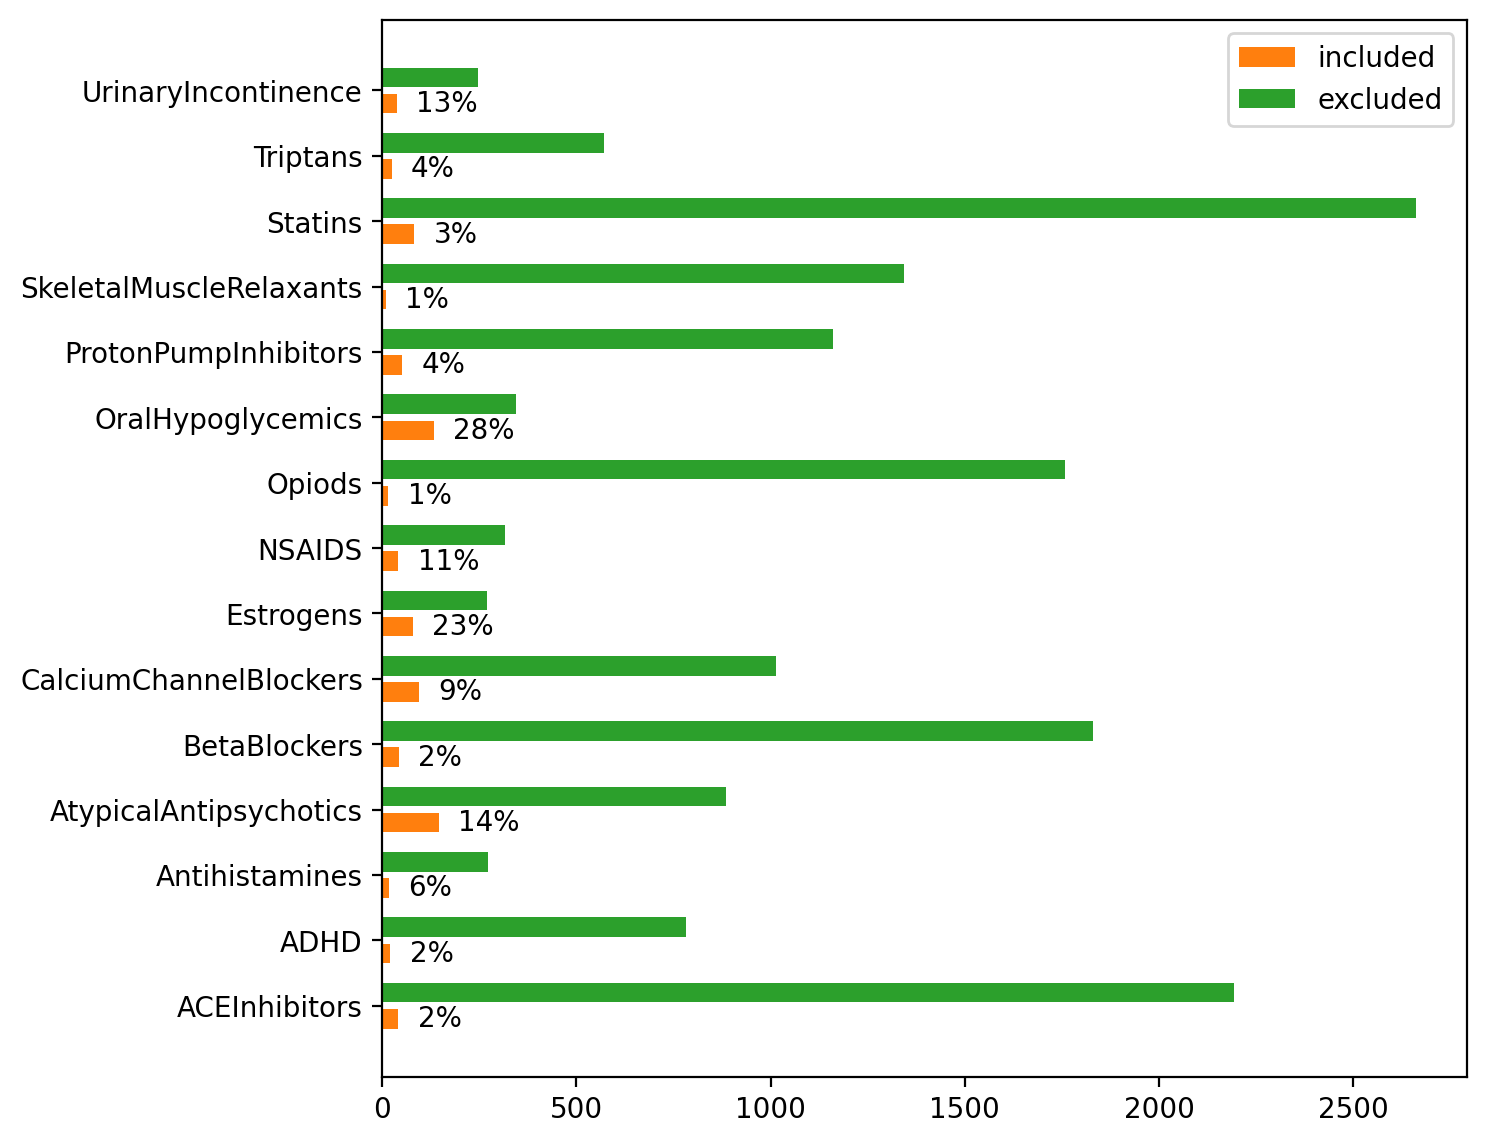

In [5]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

cm = plt.cm.RdYlBu


ticklabels = []
for i, (name, group) in enumerate(cohen_db.groupby('review')):
    if i==0:
        l1="included"
        l2="excluded"
    else:
        l1 = None
        l2 = None
        
    group = pd.merge(
        group,
        document_index,
    )
    group = group.dropna()
    included = group[group['relevant']==1].shape[0]
    excluded = group[group['relevant']==0].shape[0]
    ax.barh(i-0.2, included, height=0.3, color='C1',label=l1)
    ax.barh(i+0.2, excluded, height=0.3, color='C2', label=l2)
    ax.text(included+50, i-0.2, f'{included/(included+excluded):.0%}', ha="left", va="center")
    ticklabels.append(name)
        
ax.set_yticks([i for i,v in enumerate(ticklabels)])
ax.set_yticklabels(ticklabels)

ax.legend()
    
    
plt.show()

In [6]:
importlib.reload(rr)

recalculate = False
paths = True
if recalculate:
    models = [
        SVC(kernel='linear',class_weight='balanced',probability=True)
        #MultinomialNB(alpha=0.1)    
        #None
        #MLPClassifier(
        #    solver='lbfgs', 
        #    alpha=0.1,
        #    hidden_layer_sizes=(10), 
        #    random_state=1
        #)
    ]

    results = []
    rs_results = []
    paths = []
    iterations = 5

    for name, group in cohen_db.groupby('review'):
        df = pd.merge(
            group,
            document_index,
        )
        df['x'] = df['mesh'].str.cat(df['ab'],sep = " ")
        df = df[df['x']!=" "]
        df = df.dropna().reset_index(drop=True)
        #if df.shape[0] > 1000:
            #continue
        #if name not in ["Statins"]:#,"BetaBlockers"]:
        #    continue
        ss = rr.ScreenScenario(
            df, models, 200, [50,100,200], name
        )
        for i in range(iterations):
            results.append(ss.screen(i, True, alpha=0.95, max_switch=1))
            #print(ss.recall_rs)
        break

    results_df = pd.DataFrame.from_dict(results)

    
else:
    dfs = []
    for suffix, label in [("","cohen"), ("_pb_copd","copd_pb"), ("_fr", "fastread")]:
        for i in range(100):
            df = pd.read_csv(f'../results/results{suffix}_{i}.csv')
            df['data_source'] = label
            #df = df[df['iteration']<=9]
            #print(df['iteration'].max())
            dfs.append(df)
    results_df = pd.concat(dfs)
    print(results_df.shape)

    for p in ["nr_prob_target_path","prob_target_path", "recall_track", "work_track","random_work_track","random_recall_track"]:
        if paths:
            try:
                results_df[p] = results_df[p].str.replace("nan","0").apply(ast.literal_eval)
            except:
                print(p)
        else:
            results_df = results_df.drop(p, axis=1)
    results_df.groupby("data_source")['iterations'].sum()


/home/max/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(4200, 62)


In [7]:
results_df.groupby("data_source")['iterations'].sum()

data_source
cohen       123662
copd_pb      25733
fastread    124250
Name: iterations, dtype: int64

In [9]:
results_df.head()

N  X_sample  alpha       bir  bir_upperbound data_source  \
0  2234       9.0   0.95  0.070000        0.114940       cohen   
1  2234      18.0   0.95  0.070000        0.096033       cohen   
2   803       4.0   0.95  0.110000        0.161531       cohen   
3   803       3.0   0.95  0.106965        0.141210       cohen   
4   287      10.0   0.95  0.298611        0.377980       cohen   

          dataset estimated_recall_path hyper_hypo_path  hypothetical_95  ...  \
0   ACEInhibitors                    []              []               18  ...   
1   ACEInhibitors                    []              []               27  ...   
2            ADHD                    []              []                9  ...   
3            ADHD                    []              []                8  ...   
4  Antihistamines                    []              []               15  ...   

    wss_bir  wss_bir_ci  wss_hyper  wss_ih  wss_ih_100 wss_ih_200  wss_ih_50  \
0  0.382274         0.0   0.144584     NaN    0.320949   0.073859   0.504924   
1  0.269472         0.0   0.074306     NaN    0.189794   0.000000   0.485676   
2  0.000000         0.0   0.120797     NaN    0.428394   0.000000   0.490660   
3  0.000000         0.0   0.087173     NaN    0.242839   0.000000   0.305106   
4  0.128920         0.0   0.034843     NaN    0.000000   0.000000   0.000000   

    wss_nrs    wss_pf  wss_rs  
0  0.124888  0.305730     NaN  
1  0.111459  0.248881     NaN  
2  0.190535  0.552927     NaN  
3  0.127024  0.393524     NaN  
4  0.048780  0.135889     NaN  

[5 rows x 62 columns]

In [12]:
results_df.columns

Index(['N', 'X_sample', 'alpha', 'bir', 'bir_upperbound', 'data_source',
       'dataset', 'estimated_recall_path', 'hyper_hypo_path',
       'hypothetical_95', 'irrelevant_heuristic', 'iteration',
       'iteration_size', 'iterations', 'last_iteration_relevance',
       'max_min_recall_path', 'max_prob_recall', 'min_prob_target', 'models',
       'n_remaining', 'n_remaining_pre_sample', 'n_sample',
       'nr_prob_target_path', 'p', 'prob_recall_path', 'prob_target',
       'prob_target_path', 'r_docs', 'r_predicted', 'r_predicted_upperbound',
       'r_seen', 'r_seen_pre_sample', 'random_recall_track',
       'random_start_recall', 'random_start_work', 'random_work_track',
       'ratings', 'recall', 'recall_bir', 'recall_bir_ci', 'recall_hyper',
       'recall_ih_100', 'recall_ih_200', 'recall_ih_50', 'recall_nrs',
       'recall_pf', 'recall_target', 'recall_track', 'results', 's',
       'seen_docs', 'work_track', 'wss_bir', 'wss_bir_ci', 'wss_hyper',
       'wss_ih', 'wss_ih_100'

Text(0, 0.5, 'Work saved')

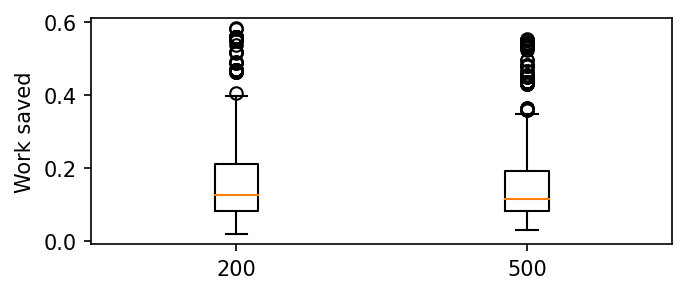

In [23]:
fig, ax = plt.subplots(dpi=150, figsize=(5,2))
x = []
xticks = []
for name, group in results_df.groupby('s'):
    xticks.append(name)
    x.append(group.wss_nrs)
ax.boxplot(x)
ax.set_xticklabels(xticks)
ax.set_ylabel("Work saved")


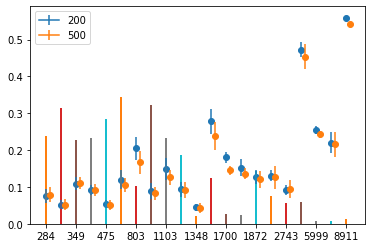

In [42]:
fig, ax = plt.subplots()
xlabs = []
xticks = []
for j, (name, group) in enumerate(results_df.groupby('N')):
    if j%2==0:
        xticks.append(j*2)
        xlabs.append(name)
    for i, (s, sgroup) in enumerate(group.groupby('s')):
        if name==results_df.N.min():
            label=s
        else:
            label=None
        ax.scatter(j*2+i/2, sgroup.wss_nrs.mean(),color=f"C{i}")
        ax.errorbar(j*2+i/2, sgroup.wss_nrs.mean(),yerr=sgroup.wss_nrs.std(),color=f"C{i}",label=label)
        ax.bar(j*2, sgroup.p.values[0], width=0.2)
        
ax.set_xticks(xticks)
ax.set_xticklabels(xlabs)
        
ax.legend()
        

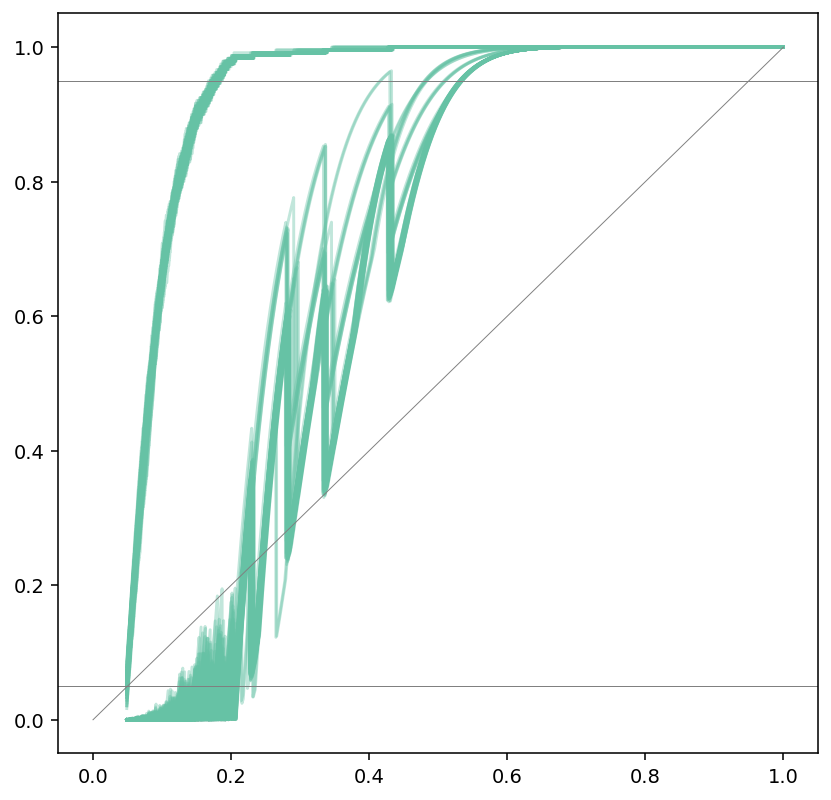

In [8]:
fig, ax = plt.subplots(figsize=(7,7),dpi=140)
for i, p in results_df[(results_df['dataset']=="ProtonBeam") & (results_df['s']==200)].iterrows():
    ax.plot(p['work_track'], 1-np.array(p['nr_prob_target_path']), c="#66c2a5", alpha=0.4)
    ax.plot(p['work_track'], p['recall_track'], c="#66c2a5", alpha=0.4)
    #ax.plot(p['recall_track'], p['nr_prob_target_path'])
    
    ax.axhline(0.05, c="grey", lw=0.5)
    ax.axhline(0.95, c="grey", lw=0.5)

    
    
ax.plot([0,1],[0,1],c="grey", lw=0.5)
    
plt.show()

In [9]:
crit = ["bir", "ih_50", "ih_200", "hyper","nrs"]

for s in crit:
    p = results_df[results_df[f'recall_{s}']>0.95].shape[0]/results_df.shape[0]
    print(f"{s}: above threshold {p:.2%}")

bir: above threshold 64.81%
ih_50: above threshold 62.86%
ih_200: above threshold 84.45%
hyper: above threshold 96.93%
nrs: above threshold 99.12%


In [10]:

#plt.boxplot(pdf['random_start_recall'])
#plt.scatter([0]*len(pdf['recall_hyper']),pdf['recall_hyper'])
#plt.scatter(pdf['iteration']+0.1,pdf['recall_hyper'])
#plt.scatter(pdf['iteration'],pdf['hyper_uinterval'])
#plt.scatter(pdf['iteration'],pdf['hyper_linterval'])

#plt.show()

/home/max/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


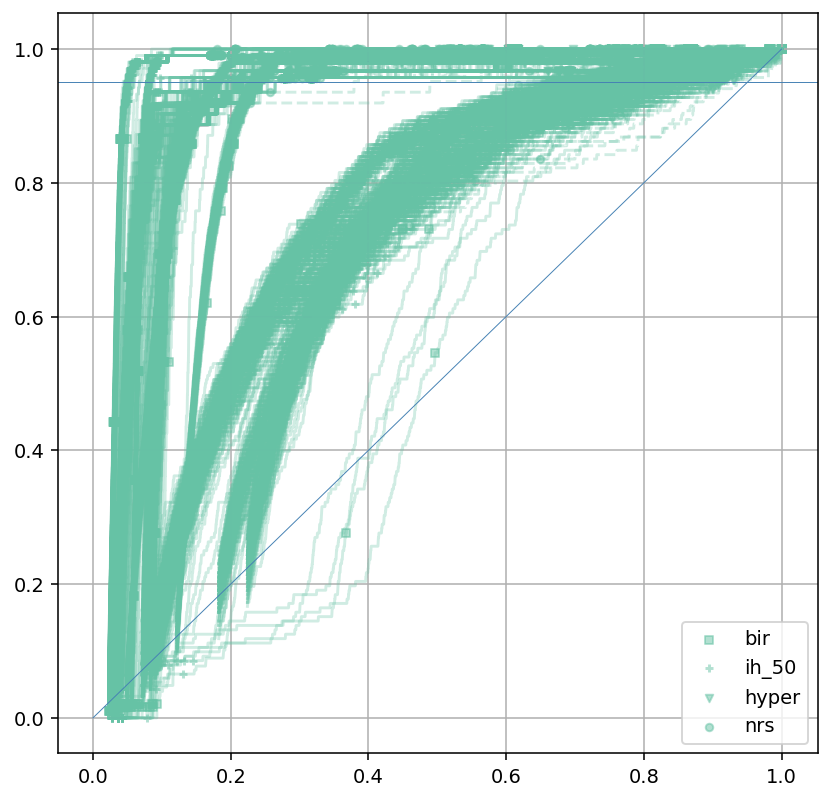

In [11]:
fig, ax = plt.subplots(figsize=(7,7),dpi=140)
colors = ['#66c2a5','#fc8d62','#8da0cb']

a = 0.3
size = 15

pdf = results_df[results_df['N'] > 2000]

for i, p in pdf.iterrows():

    ax.plot(p['work_track'], p['recall_track'], c = colors[0], alpha=a)
    ax.plot(p['random_work_track'], p['random_recall_track'], c = colors[0], alpha=a, linestyle="--")
    #ax.plot(p['random_work_track'], p['estimated_recall_path'])
    #ax.plot(p['random_work_track'], p['estimated_p_path'])
    
s_crit = ["bir","ih_50", "hyper", "nrs"]

import itertools
marker = itertools.cycle((',', '+', 'v', 'o', '*',':')) 

ax.scatter(pdf['random_start_work'],pdf['random_start_recall'],c=colors[0],s=size,alpha=a+0.2)

for s in s_crit:
    ax.scatter(
        1- pdf[f'wss_{s}'], 
        pdf[f'recall_{s}'], 
        c = colors[0], marker = next(marker),
        label = s,
        s = size,
        alpha=a+0.2
    )
    
ax.axhline(0.95, color="steelblue",lw=0.5)
ax.plot([0,1],[0,1], color="steelblue", lw=0.5)
ax.legend()
ax.grid()

plt.show()

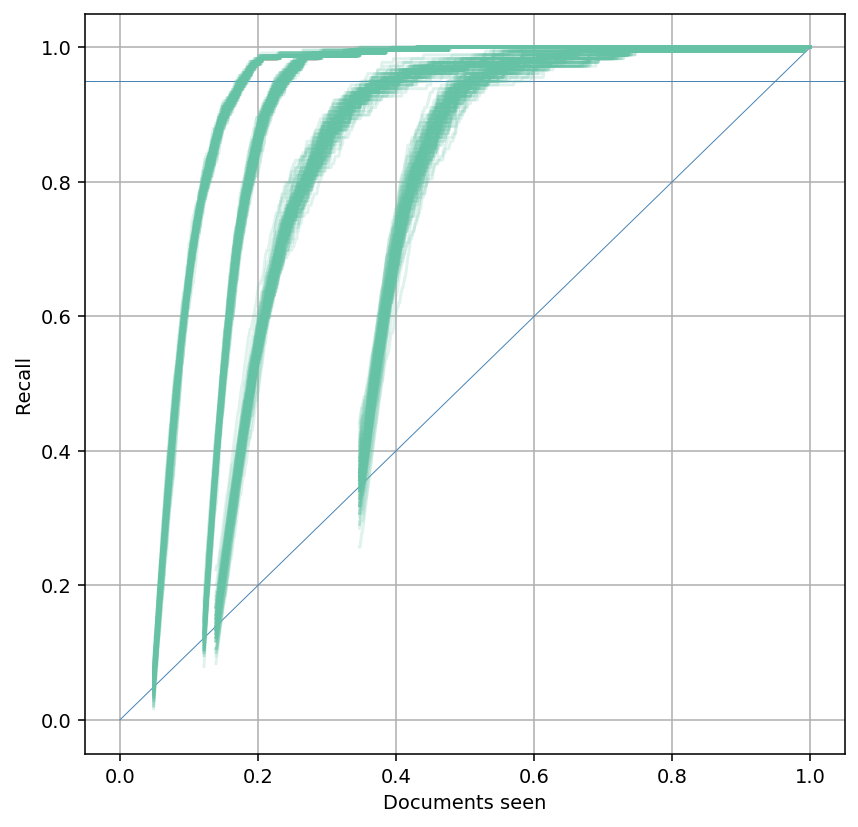

In [12]:
fig, ax = plt.subplots(figsize=(7,7),dpi=140)
colors = ['#66c2a5','#fc8d62','#8da0cb']

a = 0.2
size = 15

pdf = results_df[results_df['data_source'] == "copd_pb"]

ax.axhline(0.95, color="steelblue",lw=0.5)
ax.plot([0,1],[0,1], color="steelblue", lw=0.5)
ax.grid()

ax.set_xlabel('Documents seen')
ax.set_ylabel('Recall')

plt.savefig(f'../images/active_learning_blank.{ext}', bbox_inches="tight")

for i, p in pdf.iterrows():

    ax.plot(p['work_track'], p['recall_track'], c = colors[0], alpha=a)

plt.savefig(f'../images/active_learning_paths.{ext}', bbox_inches="tight")

    


plt.show()

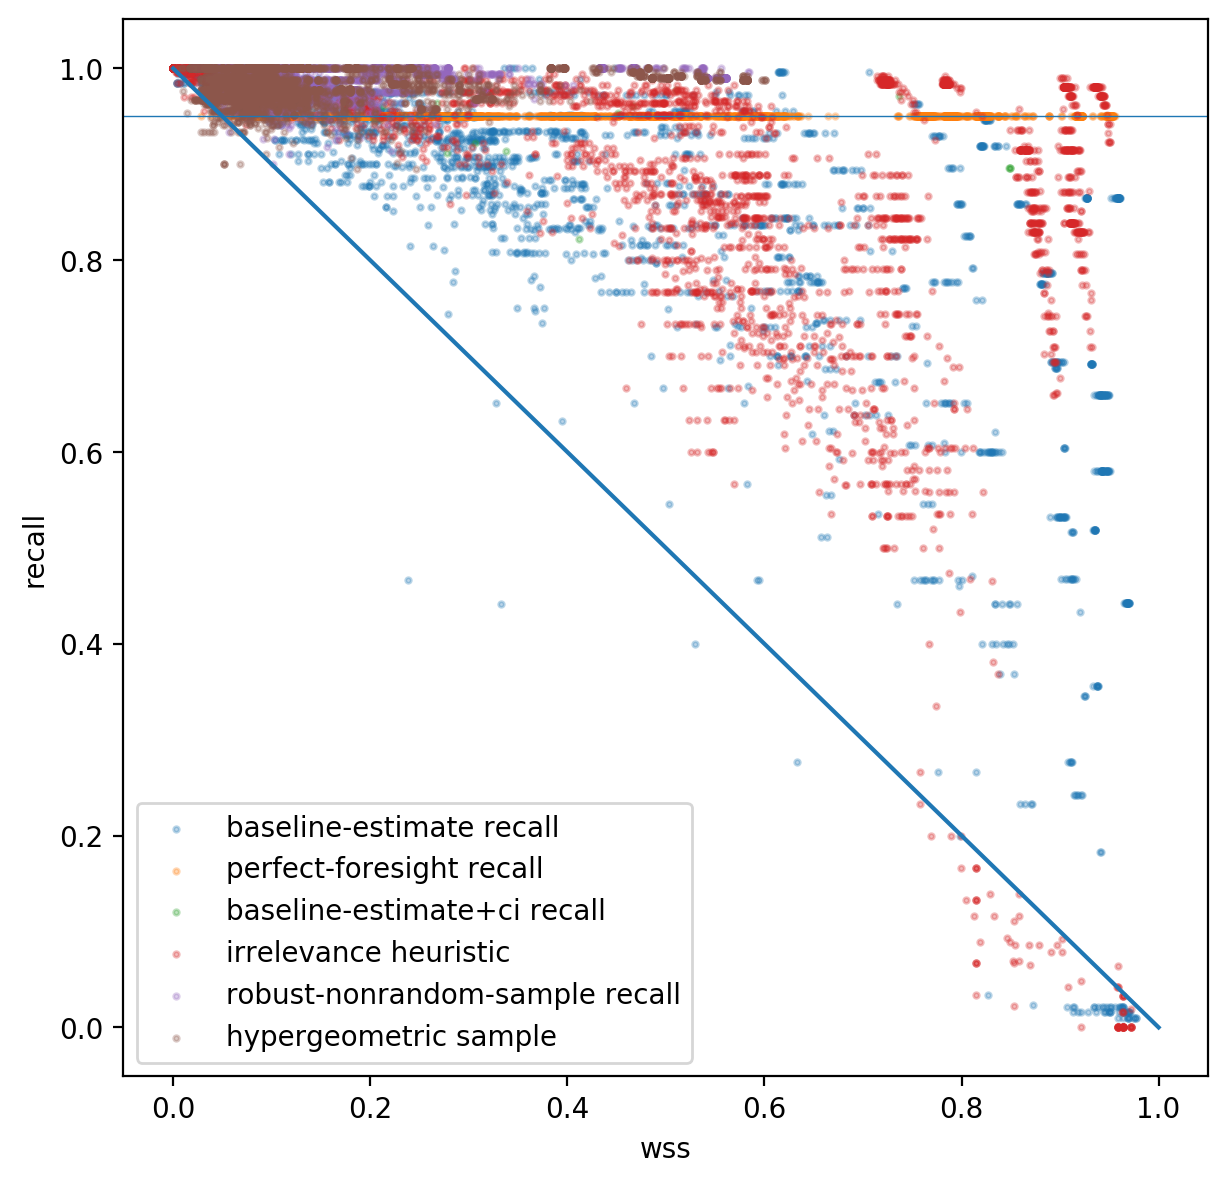

In [13]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
s = 4
a = 0.3

pdf = results_df#[results_df['data_source']=="fr"]

ax.scatter(
    pdf['wss_bir'], pdf['recall_bir'], 
    alpha=a, 
    label="baseline-estimate recall",
    s=s
)
ax.scatter(
    pdf['wss_pf'], 
    [0.95 for x in pdf['recall_pf']], 
    alpha=a,
    label="perfect-foresight recall",
    s=s
)

ax.scatter(
    pdf['wss_bir_ci'], 
    pdf['recall_bir_ci'], 
    alpha=a,
    label="baseline-estimate+ci recall",
    s=s
)

ax.scatter(
    pdf['wss_ih_50'], 
    pdf['recall_ih_50'], 
    alpha=a,
    label="irrelevance heuristic",
    s=s
)

ax.scatter(
    pdf['wss_nrs'], pdf['recall_nrs'], 
    alpha=a, 
    label="robust-nonrandom-sample recall",
    s=s
)

ax.scatter(
    pdf['wss_hyper'], pdf['recall_hyper'], 
    alpha=a, 
    label="hypergeometric sample",
    s=s
)

ax.legend()
ax.set_ylabel('recall')
ax.set_xlabel('wss')

ax.plot([1,0],)

ax.axhline(0.95, lw=0.5)
plt.show()

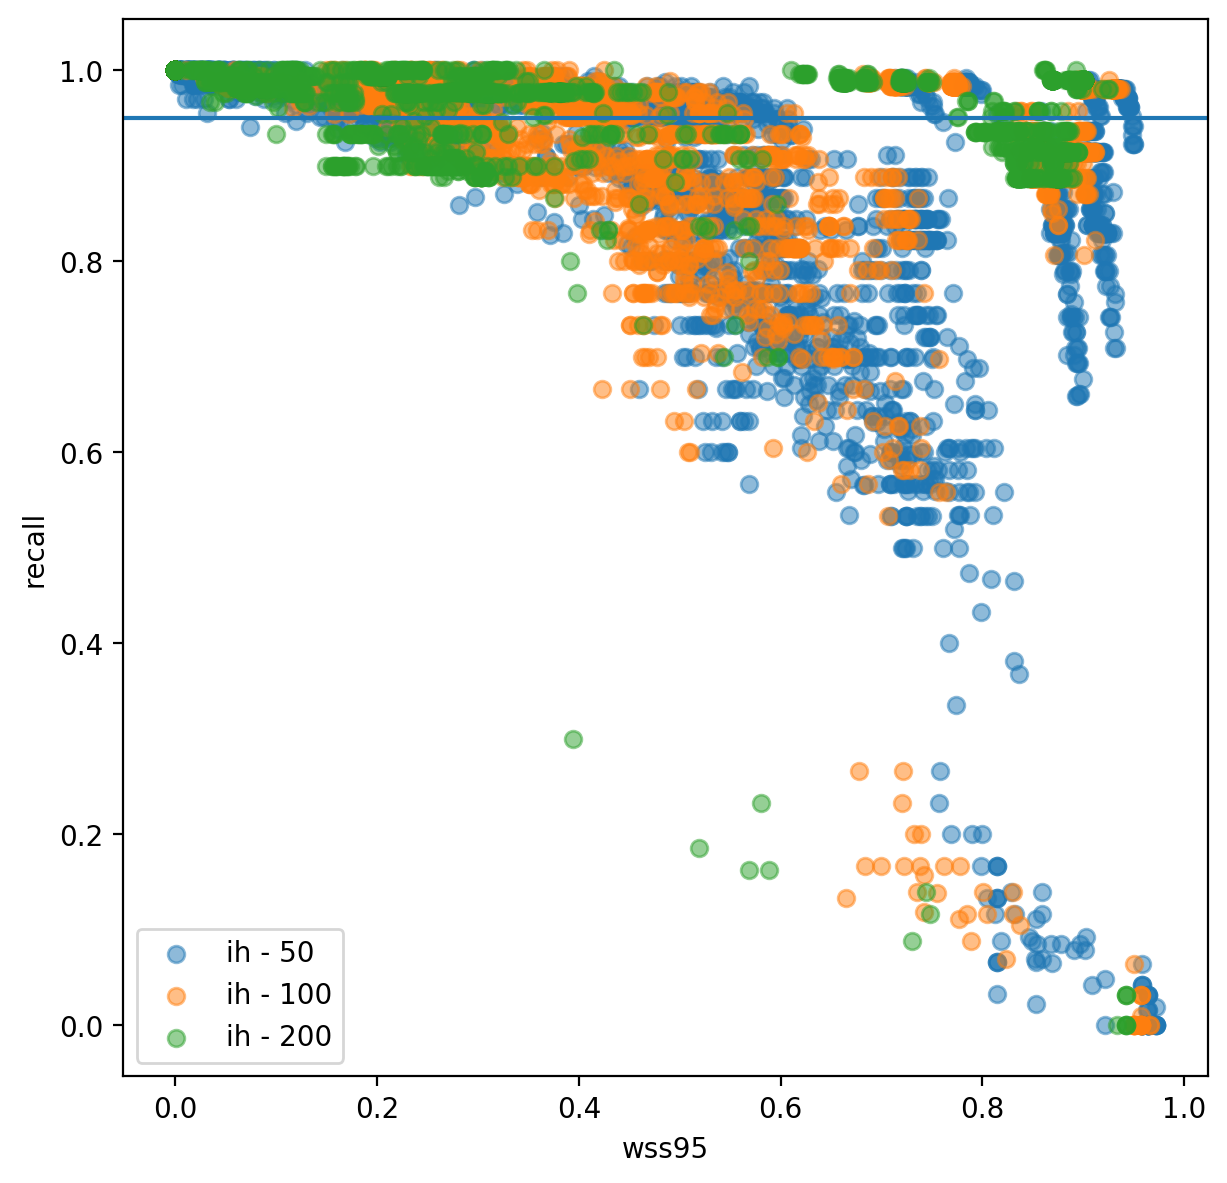

In [14]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
for ih in [50,100,200]:
    ax.scatter(
        results_df[f'wss_ih_{ih}'], results_df[f'recall_ih_{ih}'], 
        alpha=0.5, 
        label=f"ih - {ih}"
    )


ax.legend()
ax.set_ylabel('recall')
ax.set_xlabel('wss95')

ax.axhline(0.95)
plt.savefig(f"../images/ih_experiment.{ext}")
plt.show()

4200
21


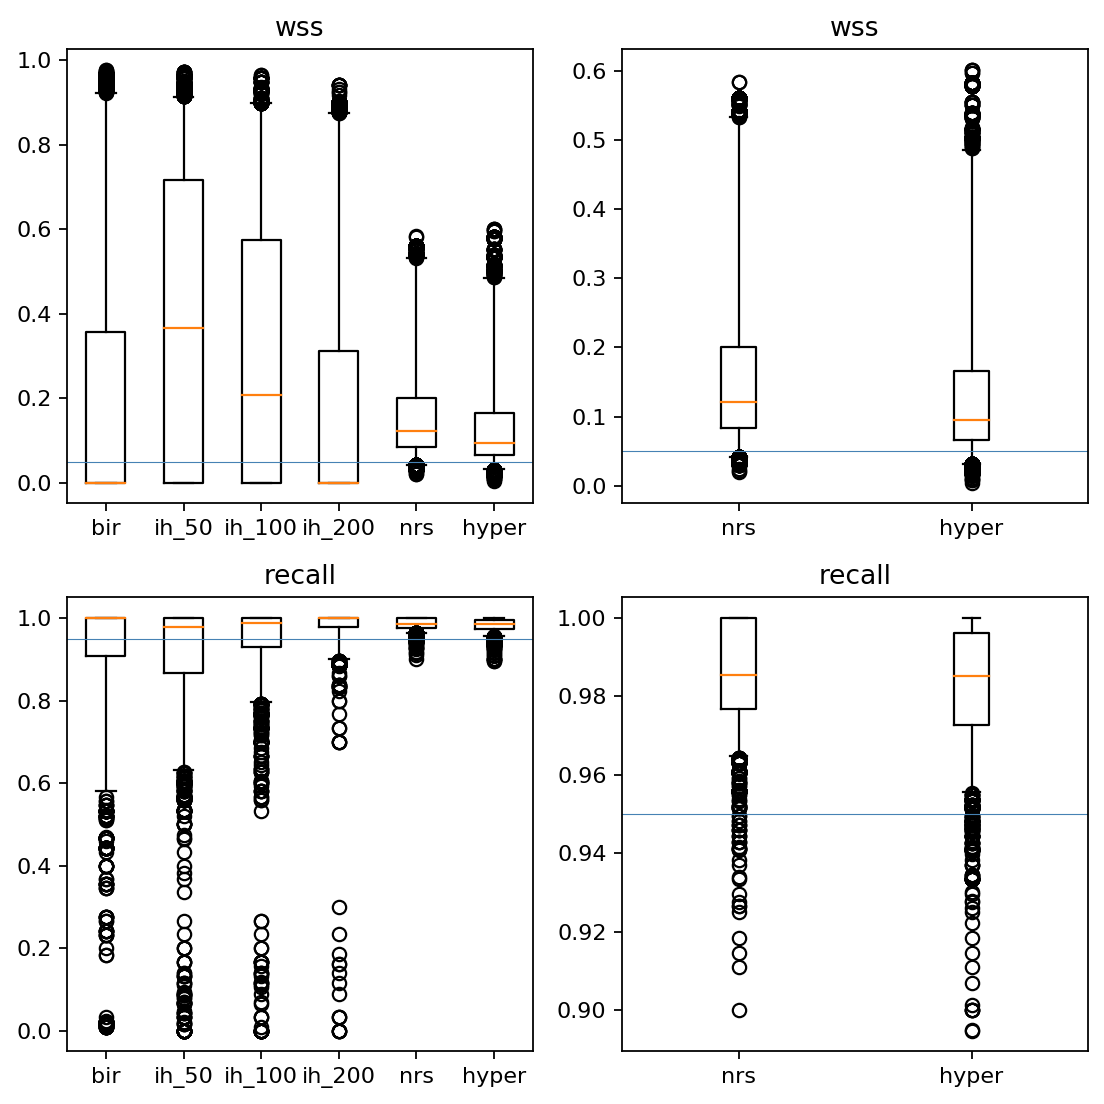

In [15]:
fig, axs = plt.subplots(2,2, figsize=(7,7),dpi=160)

s_crit = ["bir","ih_50","ih_100","ih_200", "nrs","hyper"]
rs_crit = ['nrs','hyper']

pdf = results_df[(results_df['N'] > 2000) & (pd.notnull(results_df['recall_pf']))]

pdf = results_df

print(pdf.shape[0])

print(len(pdf['dataset'].unique()))

for s in s_crit:
    pdf[f'additional_burden_f{s}'] = pdf[f"wss_{s}"] - pdf["wss_pf"]
    
for s in s_crit:
    pdf[f'missed_target{s}'] = pdf[f"recall_{s}"] - 0.95
    
    

for i, c in enumerate([s_crit, rs_crit]):
    
    for j in [(0,'wss',0.05), (1,'recall',0.95)]:

        axs[j[0]][i].boxplot([pdf[f'{j[1]}_{s}'].dropna() for s in c],whis=[5,95])
        axs[j[0]][i].set_xticklabels(c)
        axs[j[0]][i].axhline(j[2], color="grey",lw=0.5)
        
        axs[j[0]][i].set_title(j[1].replace('95',''))

fig.tight_layout()

plt.savefig(f"../images/wss_recall_boxplot.{ext}")


plt.show()

4200
21


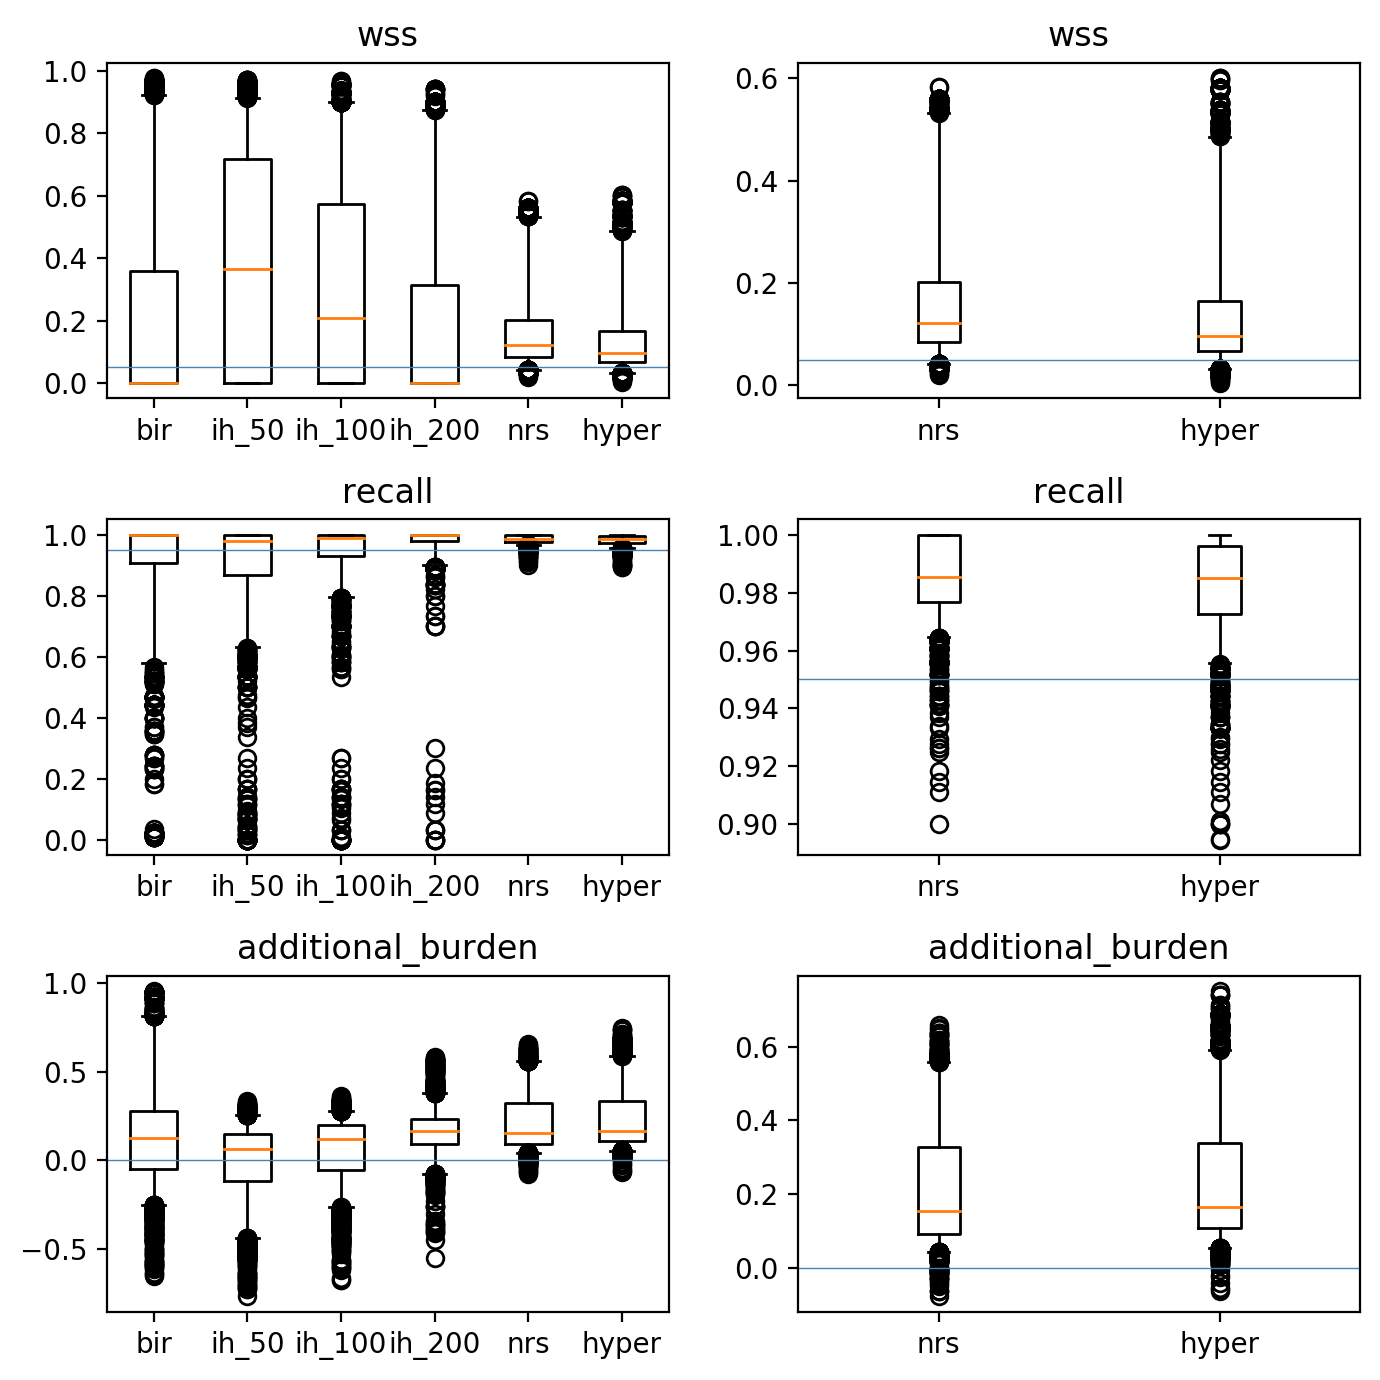

In [16]:
fig, axs = plt.subplots(3,2, figsize=(7,7),dpi=200)

rs_crit = ['nrs','hyper']

pdf = results_df[(results_df['N'] > 2000) & (pd.notnull(results_df['recall_pf']))]
pdf = results_df
print(pdf.shape[0])

print(len(pdf['dataset'].unique()))

for s in s_crit:
    pdf[f'additional_burden_{s}'] = pdf["wss_pf"] -  pdf[f"wss_{s}"]
    #pdf.loc[pdf[f'additional_burden_{s}']<0,f'additional_burden_{s}'] = 0

for s in rs_crit:
    pdf[f'additional_burden_{s}'] = pdf["wss_pf"] - pdf[f"wss_{s}"] 
    #pdf.loc[pdf[f'additional_burden_{s}']<0,f'additional_burden_{s}'] = 0
    

for i, c in enumerate([s_crit, rs_crit]):
    
    for j in [(0,'wss',0.05), (1,'recall',0.95), (2,'additional_burden',0)]:

        axs[j[0]][i].boxplot([pdf[f'{j[1]}_{s}'].dropna() for s in c],whis=[5,95])
        axs[j[0]][i].set_xticklabels(c)
        axs[j[0]][i].axhline(j[2], color="steelblue",lw=0.5)
        
        axs[j[0]][i].set_title(j[1].replace('95',''))

fig.tight_layout()

plt.savefig(f"../images/wss_recall_burden_boxplot.{ext}")


plt.show()

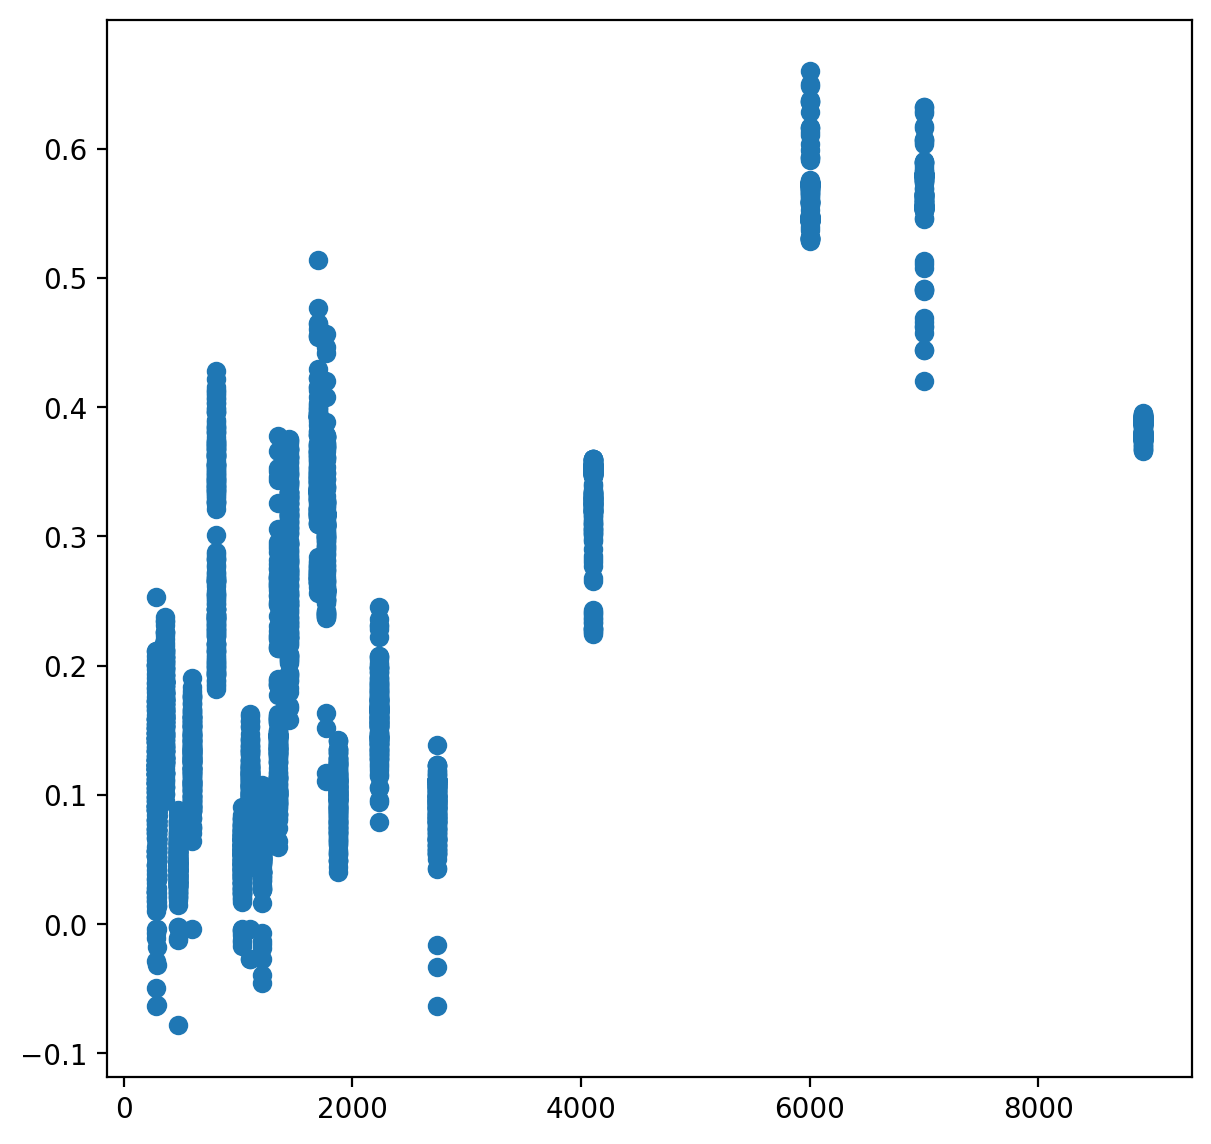

In [17]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

ax.scatter(pdf['N'],pdf['additional_burden_nrs'])

additional burden for nrs depends on
- number of relevant documents
- number of irrelevant documents?

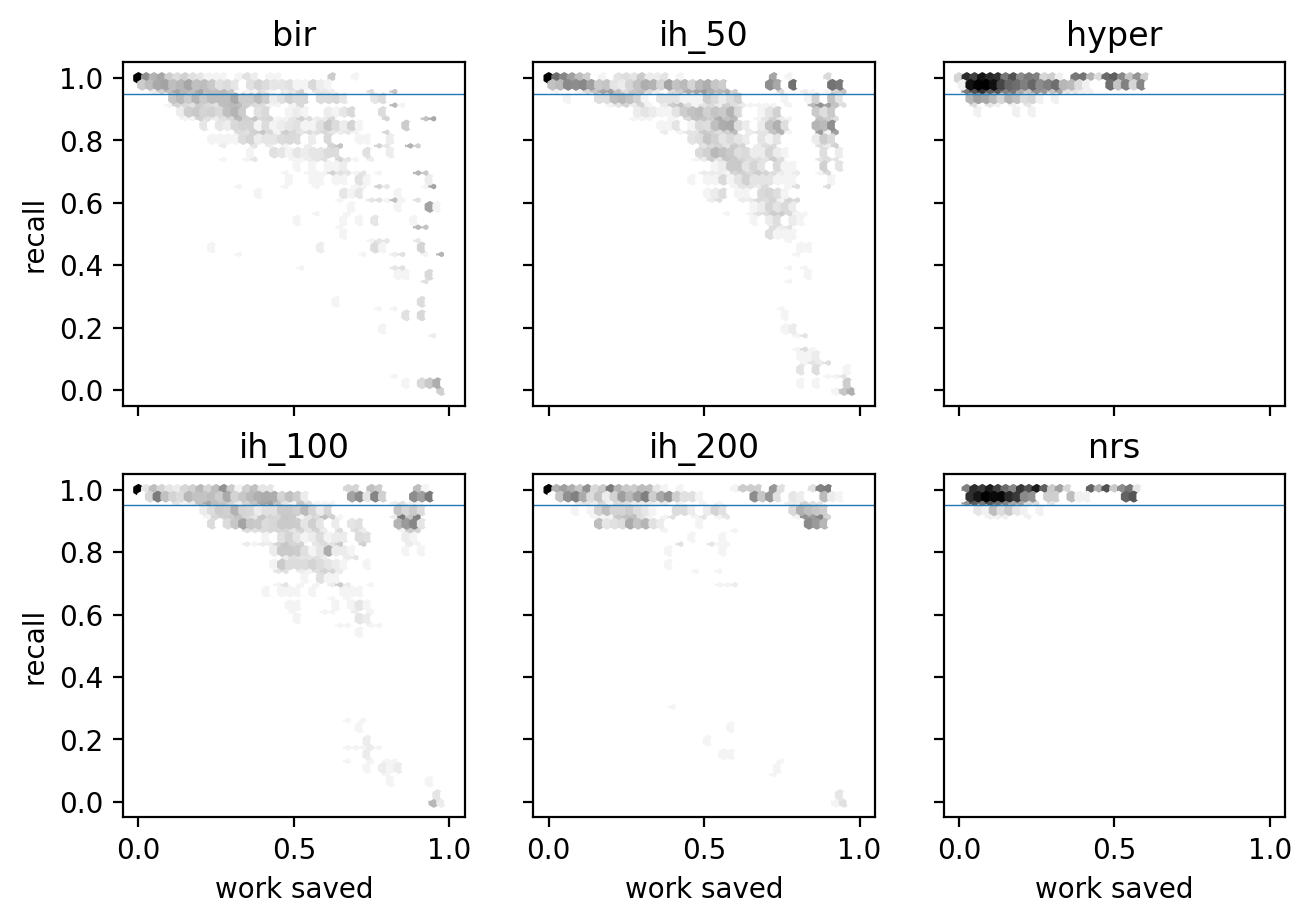

In [18]:
plt.close()

fig, axs = plt.subplots(2,3,figsize=(7.5,5),dpi=200,sharey=True, sharex=True)

cols = [f'wss_{s}' for s in s_crit] + [f'recall_{s}' for s in s_crit]

#pdf = results_df[results_df['data_source']=="copd_pb"][cols].dropna()
#pdf = results_df[results_df['data_source']=="copd_pb"][cols].dropna()
pdf = results_df

s_crit = ["bir","ih_50","hyper","ih_100", "ih_200", "nrs"]

for i, ss in enumerate(s_crit):
    ax = axs[i//3][i%3]
    ax.hexbin(
        pdf[f'wss_{ss}'].dropna(), 
        pdf[f'recall_{ss}'].dropna(), 
        gridsize=40, 
        mincnt=0,
        cmap="Greys",
        bins="log",
        extent=[0, 1, 0, 1]
    )
    ax.set_title(ss)
    #ax.plot([0,1],[1,0], lw=0.5)
    ax.axhline(0.95, lw=0.5)
    
    if i//3==1:
        ax.set_xlabel("work saved")
    if i%3==0:
        ax.set_ylabel("recall")
    
plt.savefig(f"../images/results_hex.{ext}")
plt.show()    

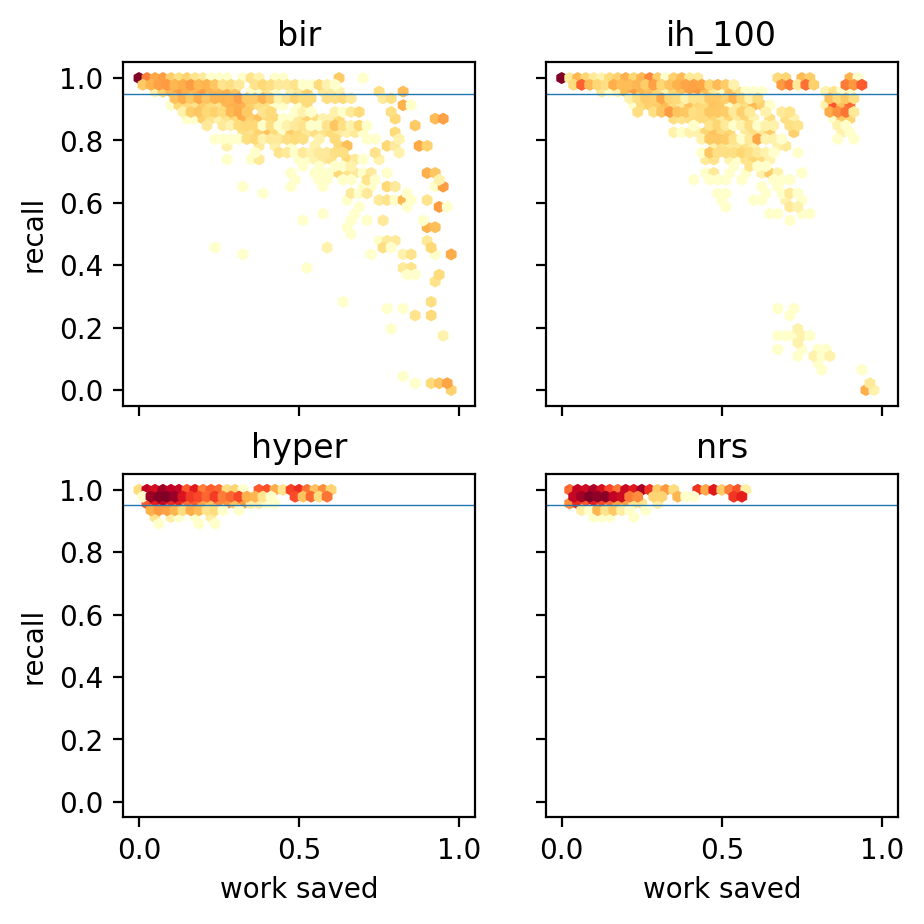

In [19]:
fig, axs = plt.subplots(2,2,figsize=(5,5),dpi=200,sharey=True, sharex=True)

cols = [f'wss_{s}' for s in s_crit] + [f'recall_{s}' for s in s_crit]

#pdf = results_df[results_df['data_source']=="copd_pb"][cols].dropna()
#pdf = results_df[results_df['data_source']=="copd_pb"][cols].dropna()
pdf = results_df

s_crit = ["bir","ih_100", "hyper", "nrs"]

for i, ss in enumerate(s_crit):
    ax = axs[i//2][i%2]
    ax.hexbin(
        pdf[f'wss_{ss}'].dropna(), 
        pdf[f'recall_{ss}'].dropna(), 
        gridsize=40, 
        mincnt=1,
        cmap="YlOrRd",
        bins="log",
        extent=[0, 1, 0, 1],
        alpha=1
    )
    ax.set_title(ss)
    #ax.plot([0,1],[1,0], lw=0.5)
    ax.axhline(0.95, lw=0.5)
    
    if i//2==1:
        ax.set_xlabel("work saved")
    if i%2==0:
        ax.set_ylabel("recall")
    
plt.savefig(f"../images/results_hex_4.{ext}", bbox_inches="tight")
plt.show()    

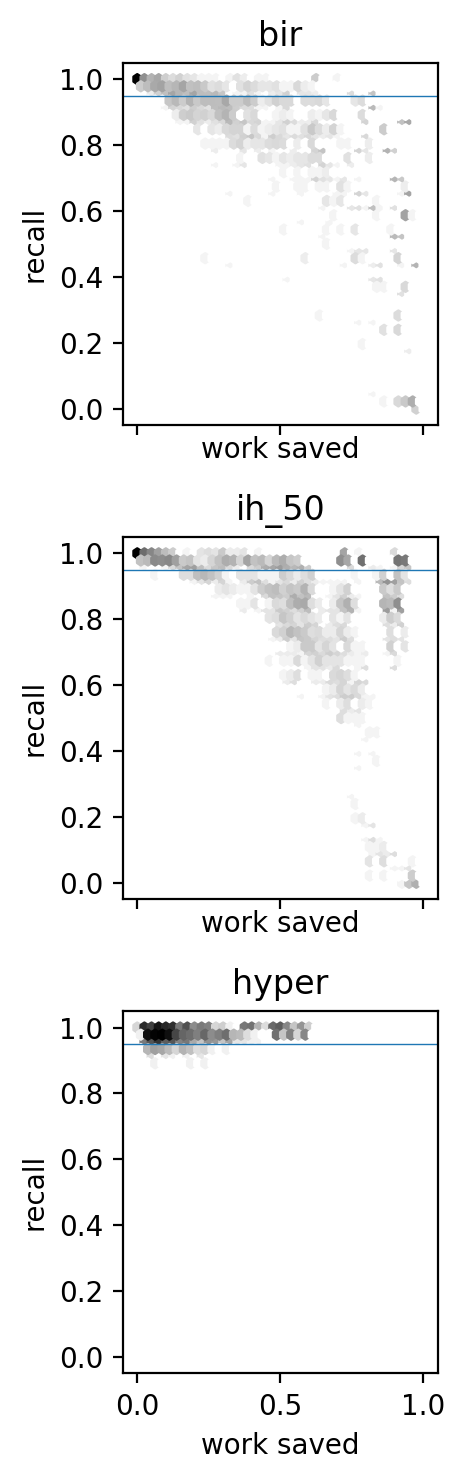

In [20]:
fig, axs = plt.subplots(3,figsize=(2.5,7.5),dpi=200,sharey=True, sharex=True)

cols = [f'wss95_{s}' for s in s_crit] + [f'recall_{s}' for s in s_crit]

#pdf = results_df[results_df['data_source']=="copd_pb"][cols].dropna()
#pdf = results_df[results_df['data_source']=="copd_pb"][cols].dropna()
pdf = results_df

s_crit = ["bir","ih_50","hyper"]

for i, ss in enumerate(s_crit):
    ax = axs[i]
    ax.hexbin(
        pdf[f'wss_{ss}'].dropna(), 
        pdf[f'recall_{ss}'].dropna(), 
        gridsize=40, 
        mincnt=0,
        cmap="Greys",
        bins="log",
        extent=[0, 1, 0, 1]
    )
    ax.set_title(ss)
    #ax.plot([0,1],[1,0], lw=0.5)
    ax.axhline(0.95, lw=0.5)

    ax.set_xlabel("work saved")
    ax.set_ylabel("recall")
    
fig.tight_layout()
    
plt.savefig(f"../images/results_hex_vert.{ext}")
plt.show()    

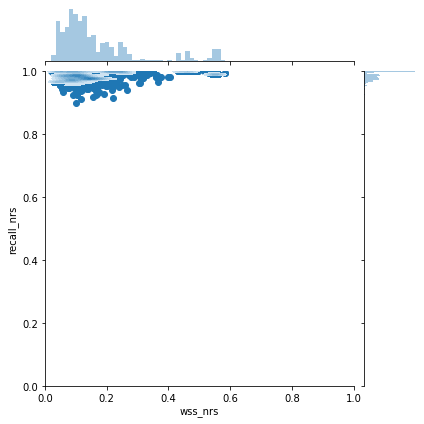

In [21]:
import seaborn as sns

g = (sns.jointplot(
        results_df['wss_nrs'], results_df['recall_nrs'],
        xlim=(0,1), ylim=(0,1)
    ).plot_joint(
    sns.kdeplot, shade=True, shade_lowest=False
))

In [22]:
cols = [['#66c2a5','#fc8d62','#8da0cb'][x] for x in pd.cut(pdf['N'],[0,1000,2000,np.inf],labels=[0,1,2])]


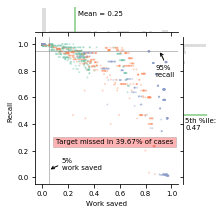

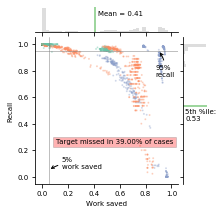

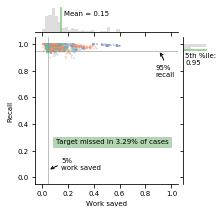

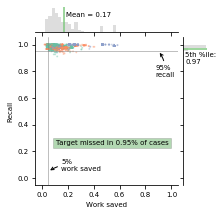

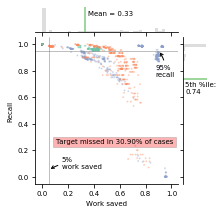

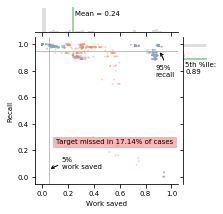

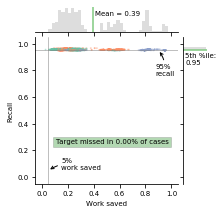

In [23]:
pdf = results_df.query('s==200')

s = 1
a = 0.3

matplotlib.rcParams['font.size'] = 7

plt.close('all')

for kde in [False]:#, True]:
    for ss in ["bir", "ih_50", "hyper", "nrs", "ih_100","ih_200", "pf"]:
        cols = [['#66c2a5','#fc8d62','#8da0cb'][x] for x in pd.cut(pdf['N'],[0,1000,2000,np.inf],labels=[0,1,2])]
        if kde:
            g = (sns.jointplot(
                    pdf[f'wss_{ss}'], pdf[f'recall_{ss}'],
                    xlim=(0,1), ylim=(0,1.04), alpha=a, s=s,
                    height=3.5, aspect=1/1,
                    scatter_kws={
                        "c":'#66c2a5'
                    },
                    marginal_kws={
                        "bins": np.arange(41)/40
                    }
            ).plot_joint(
                sns.kdeplot, n_levels=20, linewidths=0.5, alpha=0.5
                )
            )   
        else:

            g = sns.JointGrid(
                x=f'wss_{ss}', y=f'recall_{ss}', data=pdf, height=3
            )
            g = g.plot_joint(plt.scatter, alpha=a, s=s, c=cols)#, palette=sns.color_palette("Set2"))
            _ = g.ax_marg_x.hist(pdf[f'wss_{ss}'], 
                                  bins=np.arange(41)/40,
                                 alpha=0.5,
                                 color="#bdbdbd"
                                )
            _ = g.ax_marg_y.hist(pdf[f'recall_{ss}'], 
                                  orientation="horizontal",
                                 alpha=0.5,
                                 color="#bdbdbd",
                                  bins=np.arange(41)/40)
            
            
        g.ax_joint.axvline(0.05, lw=0.5,c="grey")
        g.ax_joint.axhline(0.95, lw=0.5,c="grey")
        g.ax_joint.set_xlabel("Work saved")
        g.ax_joint.set_ylabel("Recall")

        g.ax_marg_x.axvline(pdf[f'wss_{ss}'].mean(), c="#7fc97f")
        g.ax_marg_x.text(pdf[f'wss_{ss}'].mean()+0.02, g.ax_marg_x.get_ylim()[1]*0.712,f"Mean = {pdf[f'wss_{ss}'].mean():.2}", va="center")
        
        #g.ax_marg_x.text(results_df[f'wss_{ss}'].median()+0.02, g.ax_marg_x.get_ylim()[1]*1,f"Median = {results_df[f'wss_{ss}'].median():.2}", va="center")


        g.ax_marg_y.axhline(pdf[f'recall_{ss}'].quantile(0.05), c="#7fc97f")
        g.ax_marg_y.text(
            g.ax_marg_y.get_xlim()[1]*0.1, 
            pdf[f'recall_{ss}'].quantile(0.05)-0.02,
            f"5th %ile:\n{pdf[f'recall_{ss}'].quantile(0.05):.2}", va="top")

        missed = pdf[pdf[f'recall_{ss}']<0.95].shape[0] / pdf[pdf[f'recall_{ss}']<1.01].shape[0]
        
        if missed < 0.05:
            bc = "green"
        else:
            bc = "red"

        g.ax_joint.text(0.1,0.25, f"Target missed in {missed:.2%} of cases",
                       bbox={'facecolor': bc, 'alpha': 0.3, 'pad': 2,
                             'edgecolor': "grey"
                            }
                       )

        g.ax_joint.annotate("95%\nrecall", (0.9,0.95), (0.875,0.85), va="top",
                           arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc3,rad=.2")
                           )

        g.ax_joint.annotate("5%\nwork saved", (0.05,0.05), (0.15,0.1), va="center",
                       arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3,rad=.2")
                       )
        if kde:
            plt.savefig(f"../images/jointplot_kde_{ss}.{ext}")
        else:
            plt.savefig(f"../images/jointplot_{ss}.{ext}")
            
        plt.savefig(f"../images/jointplot_{ss}.pdf")
            
        plt.show()

In [24]:
pdf = results_df.query('s==200')

for n in [1500,2000]:
    pdf = results_df[results_df['N']>n]
    for kde in [False]:#, True]:
        for ss in ["bir", "ih_50", "hyper", "nrs", "ih_100","ih_200", "pf"]:
            plt.close()
            if kde:
                g = (sns.jointplot(
                        pdf[f'wss_{ss}'], pdf[f'recall_{ss}'],
                        xlim=(0,1), ylim=(0,1.04), alpha=a, s=s,
                        height=3.5,
                        marginal_kws={
                            "bins": np.arange(41)/40
                        }
                ).plot_joint(
                    sns.kdeplot, n_levels=20, linewidths=0.5, alpha=0.5
                    )
                )   
            else:
                g = (sns.jointplot(
                        pdf[f'wss_{ss}'], pdf[f'recall_{ss}'],
                        xlim=(0,1), ylim=(0,1.01), alpha=a, s=s,
                        height=3, #aspect=1/1,
                        marginal_kws={
                            "bins": np.arange(41)/40
                        }
                ))        
            g.ax_joint.axvline(0.05, lw=0.5,c="grey")
            g.ax_joint.axhline(0.95, lw=0.5,c="grey")
            g.ax_joint.set_xlabel("Work saved")
            g.ax_joint.set_ylabel("Recall")

            g.ax_marg_x.axvline(pdf[f'wss_{ss}'].mean(), c="#7fc97f")
            g.ax_marg_x.text(pdf[f'wss_{ss}'].mean()+0.02, g.ax_marg_x.get_ylim()[1]*0.712,f"Mean = {pdf[f'wss_{ss}'].mean():.2}", va="center")

            #g.ax_marg_x.text(results_df[f'wss_{ss}'].median()+0.02, g.ax_marg_x.get_ylim()[1]*1,f"Median = {results_df[f'wss_{ss}'].median():.2}", va="center")


            g.ax_marg_y.axhline(pdf[f'recall_{ss}'].quantile(0.05), c="#7fc97f")
            g.ax_marg_y.text(
                g.ax_marg_y.get_xlim()[1]*0.1, 
                pdf[f'recall_{ss}'].quantile(0.05)-0.02,
                f"5th %ile:\n{pdf[f'recall_{ss}'].quantile(0.05):.2}", va="top")

            missed = pdf[pdf[f'recall_{ss}']<0.95].shape[0] / pdf[pdf[f'recall_{ss}']<1.01].shape[0]

            if missed < 0.05:
                bc = "green"
            else:
                bc = "red"

            g.ax_joint.text(0.1,0.25, f"Target missed in {missed:.2%} of cases",
                           bbox={'facecolor': bc, 'alpha': 0.3, 'pad': 2,
                                 'edgecolor': "grey"
                                }
                           )

            g.ax_joint.annotate("95%\nrecall", (0.9,0.95), (0.875,0.85), va="top",
                               arrowprops=dict(arrowstyle="->",
                                        connectionstyle="arc3,rad=.2")
                               )

            g.ax_joint.annotate("5%\nwork saved", (0.05,0.05), (0.15,0.1), va="center",
                           arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc3,rad=.2")
                       )
            if kde:
                plt.savefig(f"../images/jointplot_kde_{n}_{ss}.{ext}")
            else:
                plt.savefig(f"../images/jointplot_{n}_{ss}.{ext}")

            plt.close()

<Figure size 252x252 with 0 Axes>

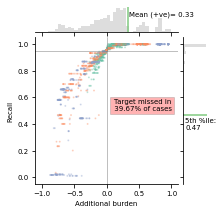

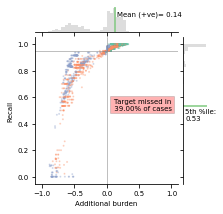

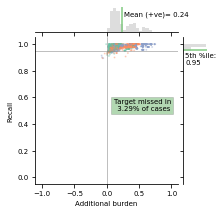

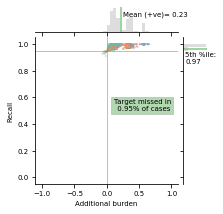

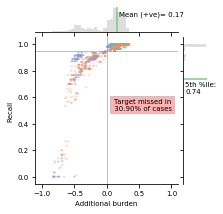

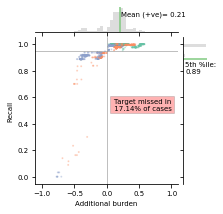

In [25]:
pdf = results_df.query('s==200')

plt.close('all')

plt.figure(figsize=(3.5,3.5))

for n in [0]:#,1500,2000]:
    pdf = pdf.query(f'N>{n}')
    for kde in [False]:#, True]:
        for ss in ["bir", "ih_50", "hyper", "nrs", "ih_100","ih_200"]:
            results_df[f'additional_burden_{ss}'] = (results_df["wss_pf"] -  results_df[f"wss_{ss}"])
            pdf[f'additional_burden_{ss}'] = (pdf["wss_pf"] -  pdf[f"wss_{ss}"]) #/ results_df["wss_pf"]
            pdf = pdf.reset_index(drop=True)
            cols = [['#66c2a5','#fc8d62','#8da0cb'][x] for x in pd.cut(pdf['N'],[0,1000,2000,np.inf],labels=[0,1,2])]
            #results_df[f'additional_burden_{ss}'] = np.log(results_df["wss_pf"] / results_df[f"wss_{ss}"] ) / #np.log(results_df["wss_pf"])

            pdf.loc[pdf[f'additional_burden_{ss}'] < 0, f'additional_burden_{ss}'] = (pdf["wss_pf"] -  pdf[f"wss_{ss}"]) / (1 - pdf["wss_pf"])


            g = sns.JointGrid(
                x=f'additional_burden_{ss}', y=f'recall_{ss}', data=pdf,height=3
            )
            g = g.plot_joint(plt.scatter, alpha=a, s=s,c=cols)
            _ = g.ax_marg_x.hist(pdf[f'additional_burden_{ss}'], 
                                  bins=(np.arange(41)-20)/20,
                                 alpha=0.5,
                                 color="#bdbdbd"
                                )
            _ = g.ax_marg_y.hist(pdf[f'recall_{ss}'], 
                                  orientation="horizontal",
                                 alpha=0.5,
                                 color="#bdbdbd",
                                  bins=np.arange(41)/40)


            g.ax_joint.axvline(0.0, lw=0.5,c="grey")
            g.ax_joint.axhline(0.95, lw=0.5,c="grey")
            g.ax_joint.set_xlabel("Additional burden")
            g.ax_joint.set_ylabel("Recall")
            
            m = pdf.query(f'additional_burden_{ss}>=0')[f'additional_burden_{ss}'].mean()

            g.ax_marg_x.axvline(m, c="#7fc97f")
            g.ax_marg_x.text(
                m+0.02, g.ax_marg_x.get_ylim()[1]*.712,
                f"Mean (+ve)= {m:.2}", va="center"
            )

            #g.ax_marg_x.text(results_df[f'wss_{ss}'].median()+0.02, g.ax_marg_x.get_ylim()[1]*1,f"Median = {results_df[f'wss_{ss}'].median():.2}", va="center")
    

            g.ax_marg_y.axhline(pdf[f'recall_{ss}'].quantile(0.05), c="#7fc97f")
            g.ax_marg_y.text(
                g.ax_marg_y.get_xlim()[1]*0.1, 
                pdf[f'recall_{ss}'].quantile(0.05)-0.02,
                f"5th %ile:\n{pdf[f'recall_{ss}'].quantile(0.05):.2}", va="top")

            missed = pdf[pdf[f'recall_{ss}']<0.95].shape[0] / pdf[pdf[f'recall_{ss}']<1.01].shape[0]

            if missed < 0.05:
                bc = "green"
            else:
                bc = "red"

            g.ax_joint.text(0.55,0.5, f"Target missed in\n {missed:.2%} of cases",
                           bbox={'facecolor': bc, 'alpha': 0.3, 'pad': 2,
                                 'edgecolor': "grey"
                                },
                            ha="center"
                           )
            g.fig.set_figheight(3)
            if kde:
                plt.savefig(f"../images/jointplot_burden_kde_{n}_{ss}.{ext}")
            else:
                plt.savefig(f"../images/jointplot_burden_{n}_{ss}.{ext}")
                
            plt.savefig(f"../images/jointplot_burden_{ss}.pdf")
                
            plt.show()


## Explaining extra burden

Additional burden is the maximum possible work saved (with perfect knowledge) minus the work saved with a given criterion. Negative values indicate that the criterion was triggered to early (resulting in missing the recall target). Positive values indicate that the criterion was triggered too late (resulting in working more than was necessary to achieve the target)

In [26]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore
results_df.columns

Index(['N', 'X_sample', 'alpha', 'bir', 'bir_upperbound', 'data_source',
       'dataset', 'estimated_recall_path', 'hyper_hypo_path',
       'hypothetical_95', 'irrelevant_heuristic', 'iteration',
       'iteration_size', 'iterations', 'last_iteration_relevance',
       'max_min_recall_path', 'max_prob_recall', 'min_prob_target', 'models',
       'n_remaining', 'n_remaining_pre_sample', 'n_sample',
       'nr_prob_target_path', 'p', 'prob_recall_path', 'prob_target',
       'prob_target_path', 'r_docs', 'r_predicted', 'r_predicted_upperbound',
       'r_seen', 'r_seen_pre_sample', 'random_recall_track',
       'random_start_recall', 'random_start_work', 'random_work_track',
       'ratings', 'recall', 'recall_bir', 'recall_bir_ci', 'recall_hyper',
       'recall_ih_100', 'recall_ih_200', 'recall_ih_50', 'recall_nrs',
       'recall_pf', 'recall_target', 'recall_track', 'results', 's',
       'seen_docs', 'work_track', 'wss_bir', 'wss_bir_ci', 'wss_hyper',
       'wss_ih', 'wss_ih_100'

In [27]:
model = smf.ols(
    'wss_nrs ~ N + p', 
    data=results_df[['wss_nrs','N','p','wss_pf']]\
        .dropna().apply(zscore)
).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                wss_nrs   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     2976.
Date:                Thu, 28 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:10:44   Log-Likelihood:                -4105.1
No. Observations:                4200   AIC:                             8216.
Df Residuals:                    4197   BIC:                             8235.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.359e-16      0.010   2.38e-14      1.000      -0.019       0.019
N              0.7710      0.013     57.857      0.000       0.745       0.797
p              0.0078      0.013      0.586      0.558      -0.018       0.034
==============================================================================
Omnibus:                      454.523   Durbin-Watson:                   0.676
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              670.063
Skew:                           0.812   Prob(JB):                    3.15e-146
Kurtosis:                       4.090   Cond. No.                         2.24
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

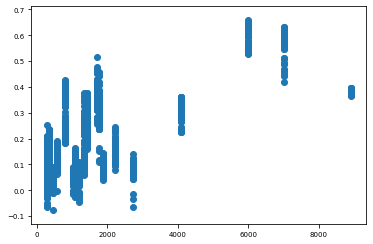

In [28]:
plt.scatter(results_df['N'],results_df['additional_burden_nrs'])

In [29]:
model_df = pd.DataFrame({
    "b":model.params,
    "ab": abs(model.params),
    "bse": model.bse,
})
model_df['c'] = model_df.index
model_df.head()

b            ab       bse          c
Intercept  2.359224e-16  2.359224e-16  0.009926  Intercept
N          7.710104e-01  7.710104e-01  0.013326          N
p          7.812408e-03  7.812408e-03  0.013326          p

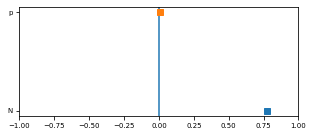

In [30]:
model_df = model_df.query(
    'index!="Intercept"'
).sort_values(
    'ab',ascending=False
).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(5,2))

tls = []
for i, r in model_df.iterrows():
    ax.errorbar(r['b'], i, xerr=r['bse'], fmt="s")
    tls.append((i,r['c']))
    
ax.set_yticks(list(zip(*tls))[0])
ax.set_yticklabels(list(zip(*tls))[1])
    
ax.set_xlim(-1,1)
ax.axvline(0)

## Table

In [31]:
db_cols = ['dataset','data_source','N','r_docs','p',]
result_cols = ['wss_hyper','wss_nrs','recall_hyper','recall_nrs']

tdf = results_df.groupby(
    db_cols
)[result_cols].agg('mean').\
sort_values('N').reset_index()

tdf = tdf[db_cols+result_cols]

tdf[db_cols].to_latex('../tables/datasets.tex', float_format="%0.2f")

#tdf.head(21)

[]

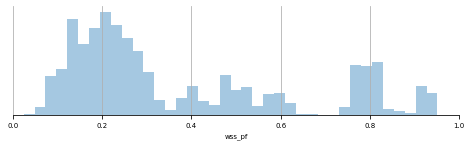

In [32]:
fig, ax = plt.subplots(figsize=(8,2))

sns.distplot(results_df['wss_pf'],ax=ax,bins=np.arange(40)/41,kde=False)

ax.grid(None)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xlim(0,1)

ax.set_yticks([])


#ax.set_xticks([])

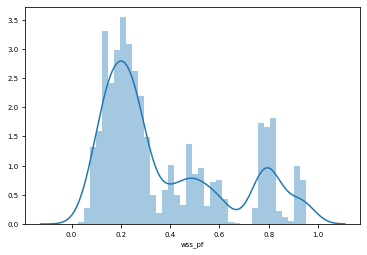

In [33]:
sns.distplot(results_df['wss_pf'],bins=np.arange(40)/41)


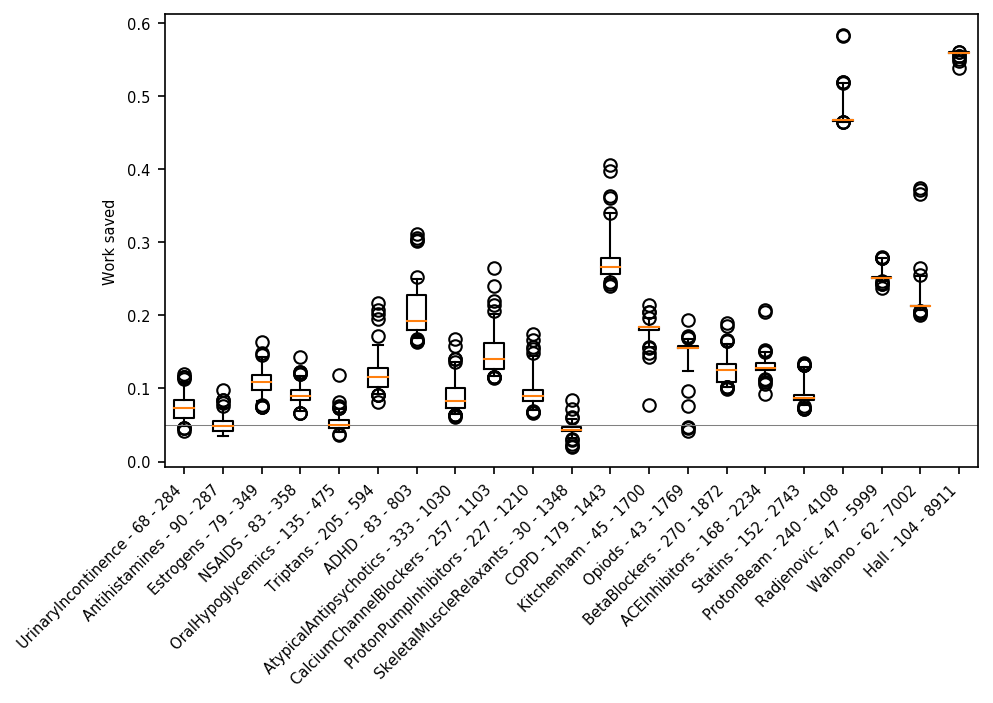

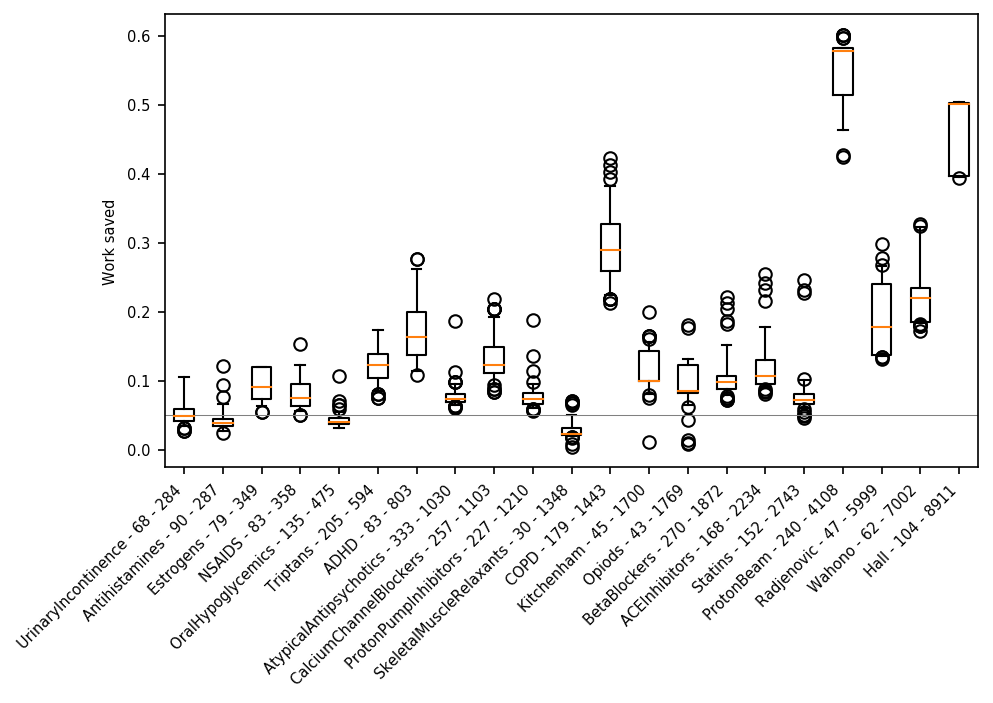

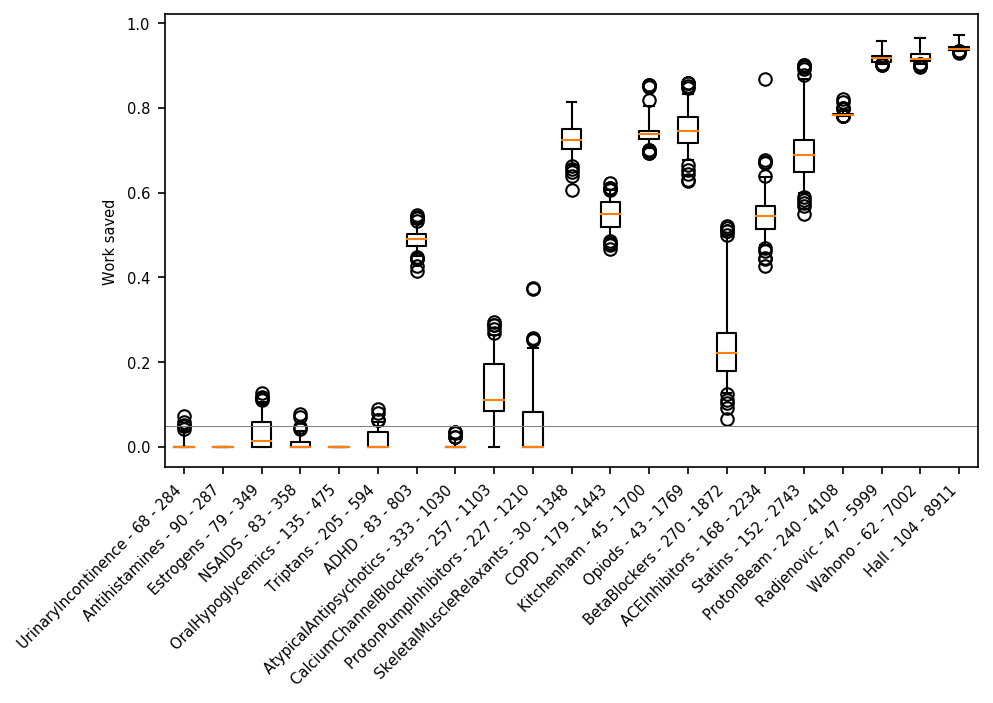

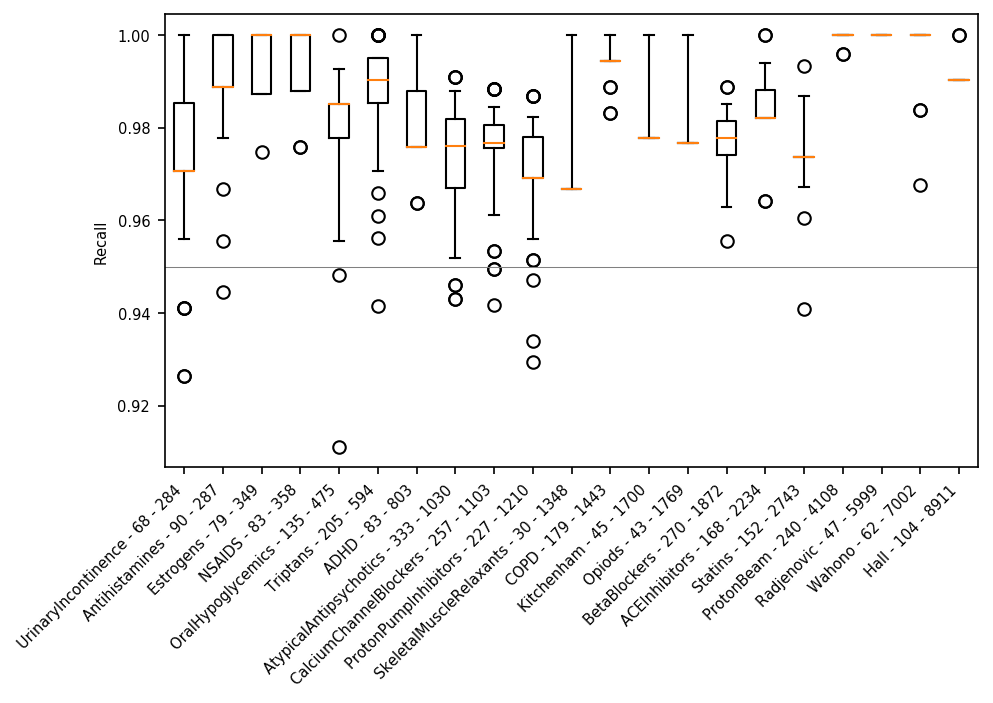

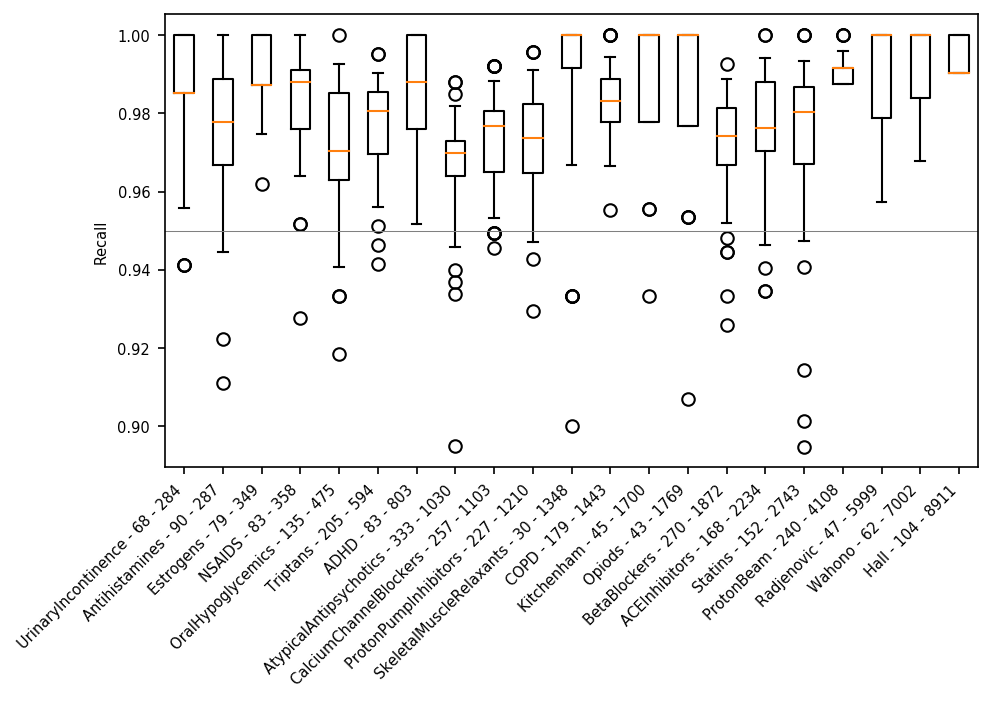

In [ ]:
datasets = results_df.groupby(['dataset','r_docs','N']).size().reset_index().sort_values('N')
datasets['label'] = datasets['dataset'].str.cat([datasets['r_docs'].astype(str), datasets['N'].astype(str)], sep = " - ")

pdf = results_df.query('s==200')

for m in [("wss","Work saved",0.05),("recall","Recall",0.95)]:
    for ss in ["nrs","hyper","ih_50"]:

        fig, ax = plt.subplots(figsize=(7,4),dpi=150)

        ax.boxplot([pdf[pdf['dataset']==d][f'{m[0]}_{ss}'].dropna() for d in datasets['dataset']], whis=[5,95])

        ax.set_xticklabels(datasets['label'], rotation=45,ha="right")
        ax.set_ylabel(m[1])
        ax.axhline(m[2], color="grey", linewidth=0.5)
        plt.savefig(f"../images/{m[0]}_{ss}.pdf",bbox_inches="tight")

In [35]:
pdf = results_df.query('s==200 & iteration==1 & dataset=="Radjenovic"').reset_index()
pdf.columns

Index(['index', 'N', 'X_sample', 'alpha', 'bir', 'bir_upperbound',
       'data_source', 'dataset', 'estimated_recall_path', 'hyper_hypo_path',
       'hypothetical_95', 'irrelevant_heuristic', 'iteration',
       'iteration_size', 'iterations', 'last_iteration_relevance',
       'max_min_recall_path', 'max_prob_recall', 'min_prob_target', 'models',
       'n_remaining', 'n_remaining_pre_sample', 'n_sample',
       'nr_prob_target_path', 'p', 'prob_recall_path', 'prob_target',
       'prob_target_path', 'r_docs', 'r_predicted', 'r_predicted_upperbound',
       'r_seen', 'r_seen_pre_sample', 'random_recall_track',
       'random_start_recall', 'random_start_work', 'random_work_track',
       'ratings', 'recall', 'recall_bir', 'recall_bir_ci', 'recall_hyper',
       'recall_ih_100', 'recall_ih_200', 'recall_ih_50', 'recall_nrs',
       'recall_pf', 'recall_target', 'recall_track', 'results', 's',
       'seen_docs', 'work_track', 'wss_bir', 'wss_bir_ci', 'wss_hyper',
       'wss_ih', 'ws

In [36]:
len(pdf['nr_prob_target_path'])

1

5029.0
3369.0
547.9999999999998
161.00000000000003


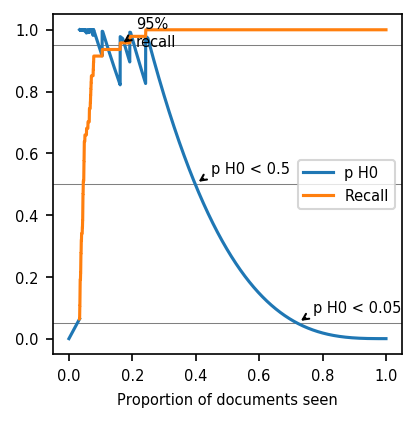

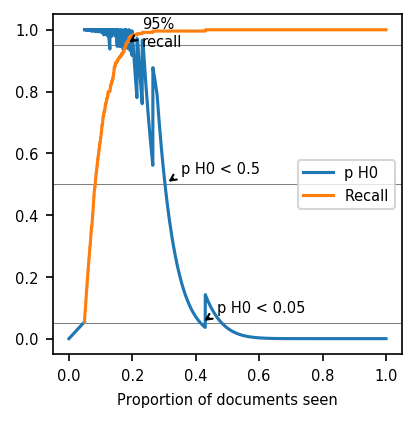

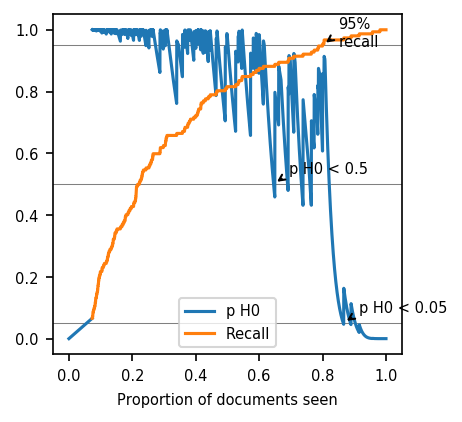

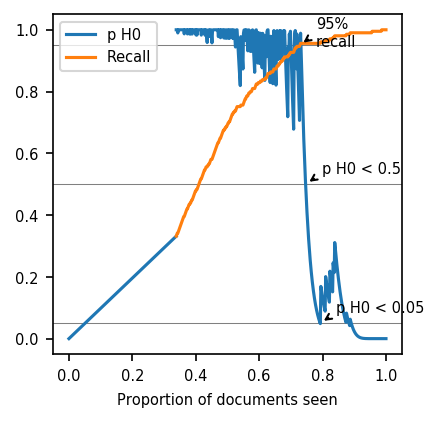

In [37]:
def plot_nr_path(pdf, ax,leg=True):

    pdf = pdf.query('recall_nrs>=0.95')
    pdf = pdf.sort_values('wss_nrs',ascending=False).reset_index(drop=True)
    t = None
    for i,y in enumerate(pdf['recall_track'][0]):
        if y > 0.95 and t is None:
            t = pdf['work_track'][0][i]

    ax.axhline(0.95, lw=0.5, c="grey")

    h_5 = None
    h_05 = None
    for i,y in enumerate(pdf['nr_prob_target_path'][0]):
        if y < 0.5 and h_5 is None:
            h_5 = pdf['work_track'][0][i]
        if y < 0.05 and h_05 is None:
            h_05 = pdf['work_track'][0][i]

    ax.axhline(0.5, lw=0.5, c="grey")
    ax.axhline(0.05, lw=0.5, c="grey")
    


    
    ax.plot(pdf['work_track'][0], pdf['nr_prob_target_path'][0],label="p H0",c="C0")
    
    ax.plot([0, pdf['work_track'][0][0]], [0, pdf['recall_track'][0][0]])   
    ax.plot(pdf['work_track'][0], pdf['recall_track'][0],label="Recall",c="C1")
    
    print(pdf['wss_pf'][0]*pdf['N'][0])

    ax.annotate("95%\nrecall", (t,0.95), (t+.05,0.99), va="center",
                       arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3,rad=.2")
                       )

    ax.annotate("p H0 < 0.5", (h_5,0.5), (h_5+.05,0.55), va="center",
                       arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3,rad=.2")
                       )

    ax.annotate("p H0 < 0.05", (h_05,0.05), (h_05+.05,0.1), va="center",
                       arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3,rad=.2")
                       )
    if leg:
        ax.legend()
        
    ax.set_xlabel('Proportion of documents seen')
        
    return ax

for d in ["Radjenovic","ProtonBeam","Statins","Triptans"]:
    pdf = results_df.query(f's==200 & dataset=="{d}"').reset_index()
    
    fig, ax = plt.subplots(figsize=(3,3), dpi=150)
    plot_nr_path(pdf, ax)
    
    plt.savefig(f"../images/h0_paths_{d}.pdf")


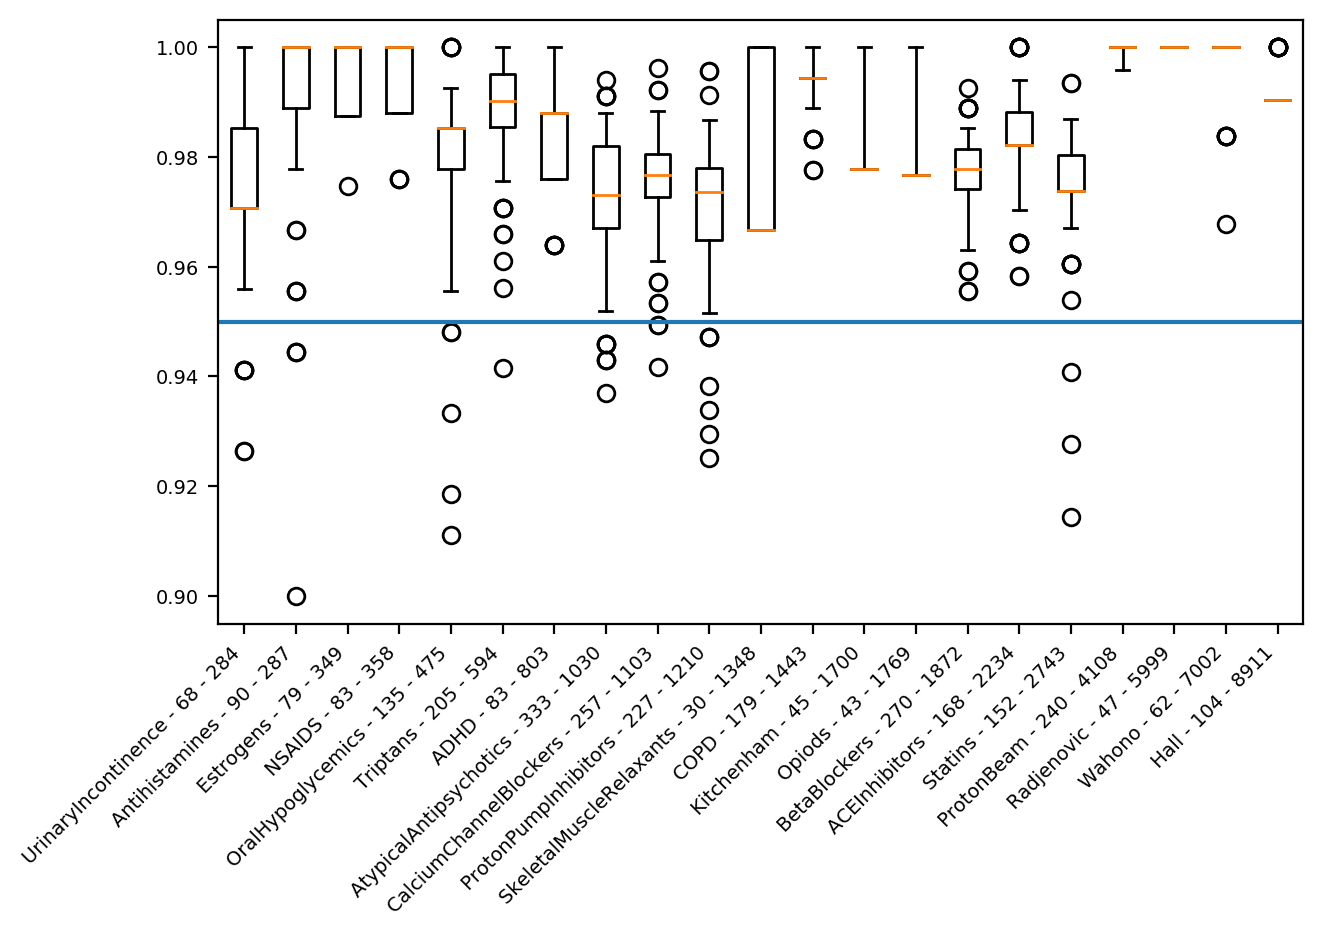

In [38]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

datasets = results_df.groupby(['dataset','r_docs','N']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat([datasets['r_docs'].astype(str), datasets['N'].astype(str)], sep = " - ")

ax.boxplot([results_df[results_df['dataset']==d]['recall_nrs'].dropna() for d in datasets['dataset']], whis=[5,95])

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")

ax.axhline(0.95)

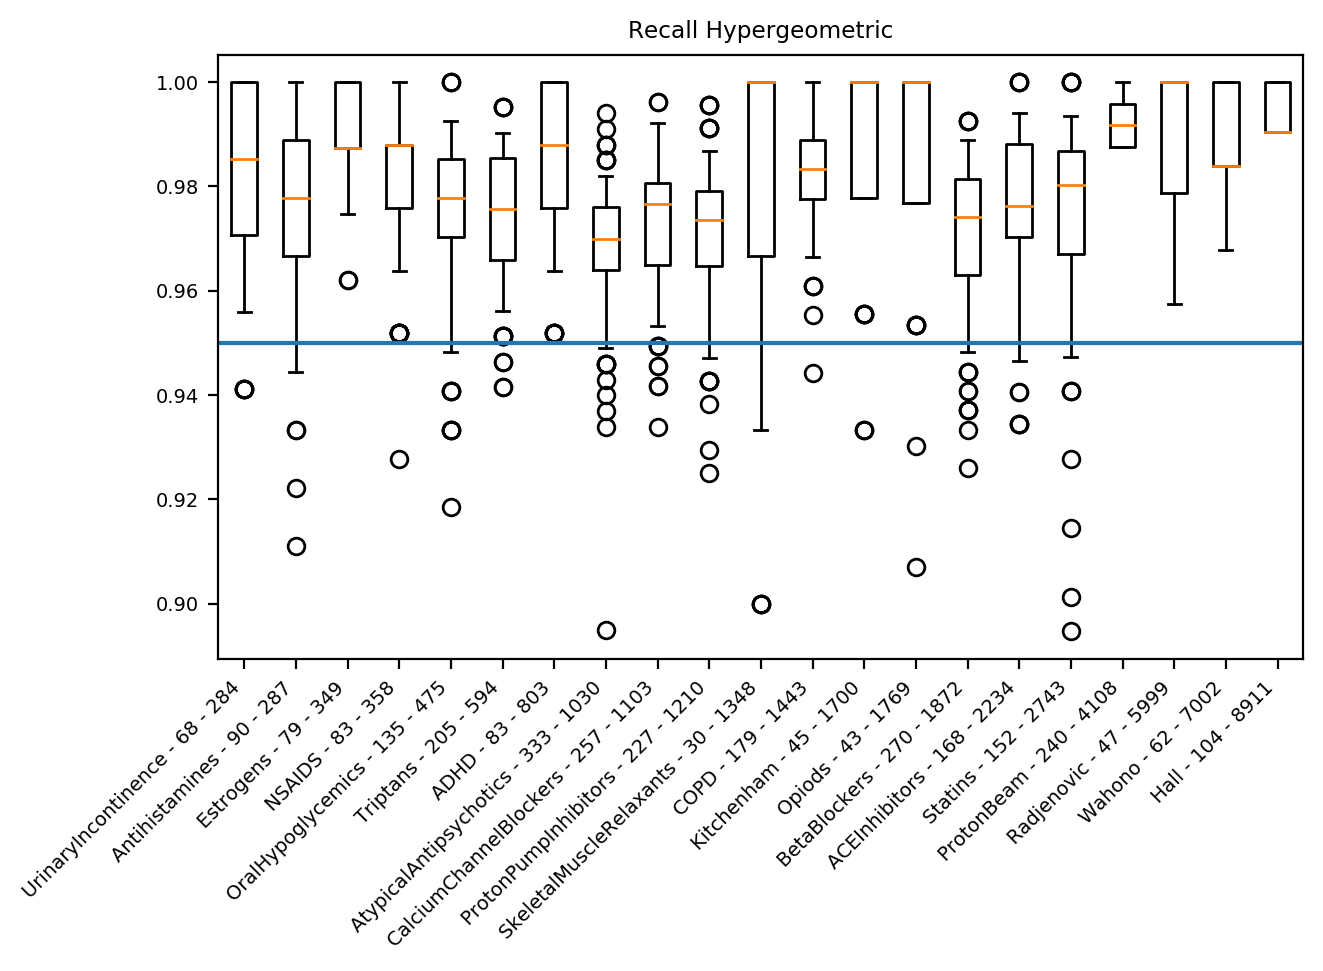

In [39]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

datasets = results_df.groupby(['dataset','r_docs','N']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat([datasets['r_docs'].astype(str), datasets['N'].astype(str)], sep = " - ")

ax.boxplot([results_df[results_df['dataset']==d]['recall_hyper'].dropna() for d in datasets['dataset']], whis=[5,95])

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")

ax.set_title("Recall Hypergeometric")

ax.axhline(0.95)

plt.show()

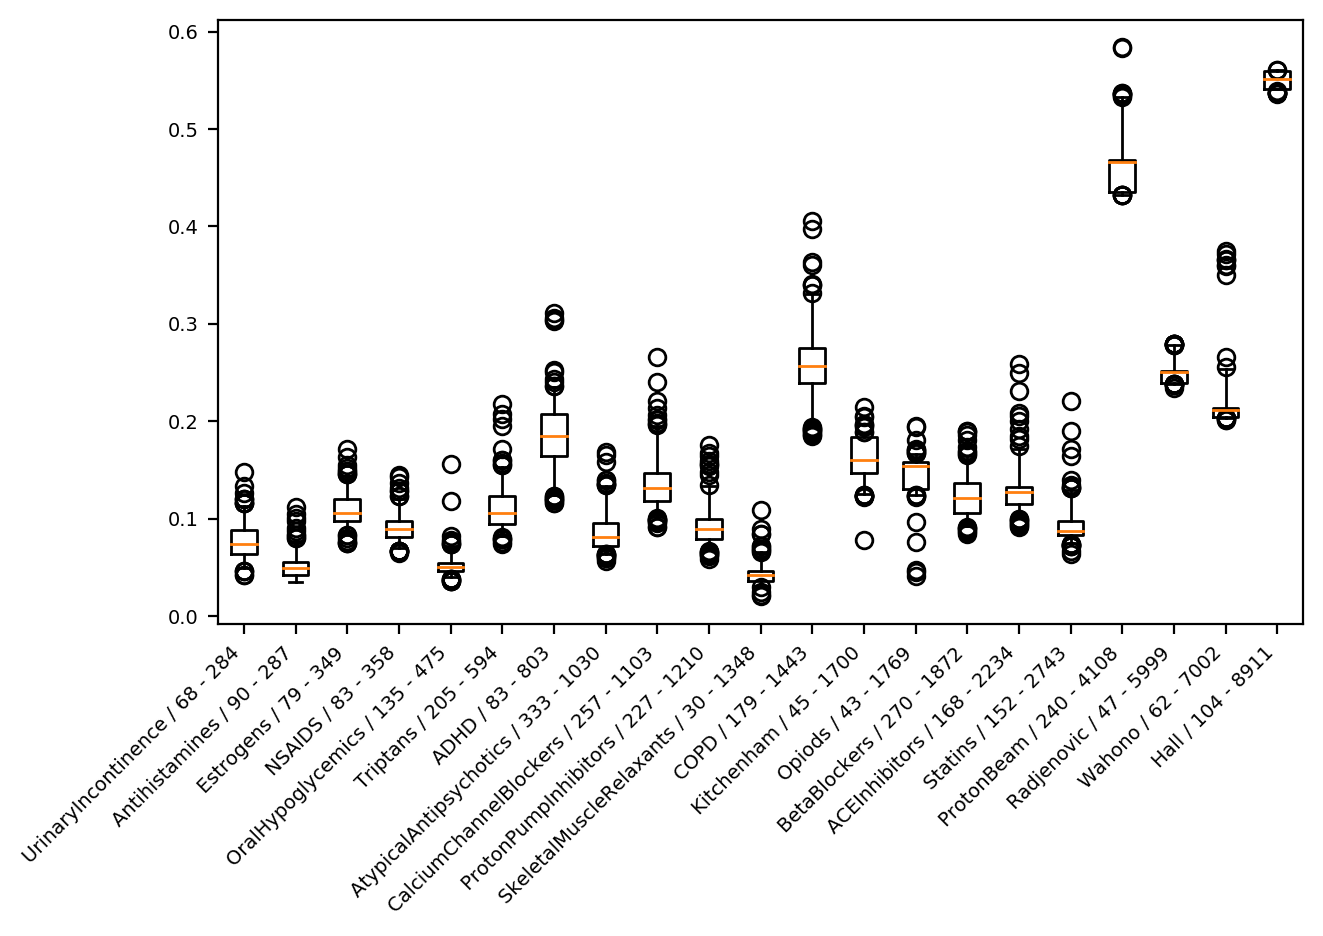

In [40]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

pdf = results_df#[results_df['N'] > 1000]

datasets = results_df.groupby(['dataset','N','r_docs']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat(datasets['r_docs'].astype(str), sep = " / ").str.cat(datasets['N'].astype(str), sep = " - ")


ax.boxplot([results_df[results_df['dataset']==d]['wss_nrs'].dropna() for d in datasets['dataset']], whis=[5,95])

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")

plt.show()

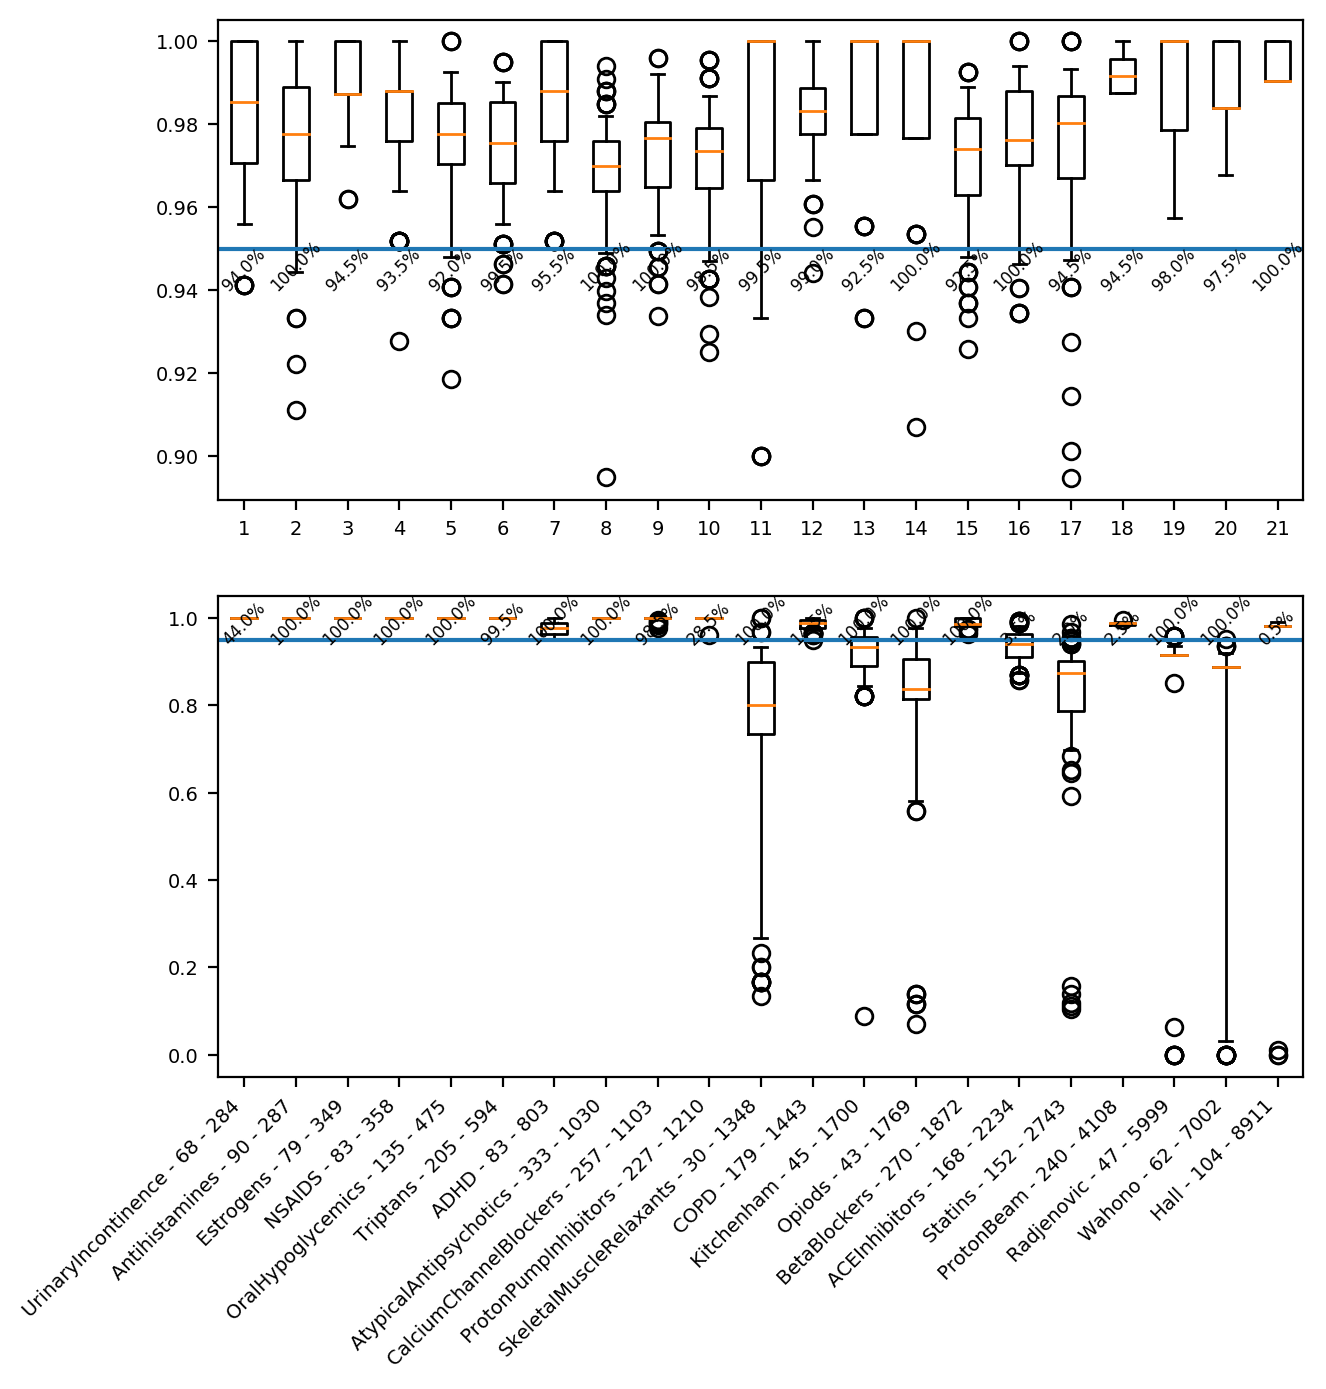

In [41]:
fig, axs = plt.subplots(2, figsize=(7,7),dpi=200)

datasets = results_df.groupby(['dataset','r_docs','N']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat([datasets['r_docs'].astype(str), datasets['N'].astype(str)], sep = " - ")

ax = axs[0]

ax.boxplot([results_df[results_df['dataset']==d]['recall_hyper'].dropna() for d in datasets['dataset']], whis=[5,95])

for i, (name, d) in enumerate(results_df.groupby('dataset')):
    p = d[d['recall_hyper']>0.95].shape[0]/d.shape[0]
    ax.text(i+1,0.94, f"{p:.1%}",fontsize=6,ha="center",rotation=45)
    
ax.axhline(0.95)    
    
ax = axs[1]


ax.boxplot([results_df[results_df['dataset']==d]['recall_ih_100'].dropna() for d in datasets['dataset']], whis=[5,95])

for i, (name, d) in enumerate(results_df.groupby('dataset')):
    p = d[d['recall_ih_100']>0.95].shape[0]/d.shape[0]
    ax.text(i+1,0.94, f"{p:.1%}",fontsize=6,ha="center",rotation=45)
    

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")

ax.axhline(0.95)

[Text(0, 0, 'UrinaryIncontinence - 68 - 284'),
 Text(0, 0, 'Antihistamines - 90 - 287'),
 Text(0, 0, 'Estrogens - 79 - 349'),
 Text(0, 0, 'NSAIDS - 83 - 358'),
 Text(0, 0, 'OralHypoglycemics - 135 - 475'),
 Text(0, 0, 'Triptans - 205 - 594'),
 Text(0, 0, 'ADHD - 83 - 803'),
 Text(0, 0, 'AtypicalAntipsychotics - 333 - 1030'),
 Text(0, 0, 'CalciumChannelBlockers - 257 - 1103'),
 Text(0, 0, 'ProtonPumpInhibitors - 227 - 1210'),
 Text(0, 0, 'SkeletalMuscleRelaxants - 30 - 1348'),
 Text(0, 0, 'COPD - 179 - 1443'),
 Text(0, 0, 'Kitchenham - 45 - 1700'),
 Text(0, 0, 'Opiods - 43 - 1769'),
 Text(0, 0, 'BetaBlockers - 270 - 1872'),
 Text(0, 0, 'ACEInhibitors - 168 - 2234'),
 Text(0, 0, 'Statins - 152 - 2743'),
 Text(0, 0, 'ProtonBeam - 240 - 4108'),
 Text(0, 0, 'Radjenovic - 47 - 5999'),
 Text(0, 0, 'Wahono - 62 - 7002'),
 Text(0, 0, 'Hall - 104 - 8911')]

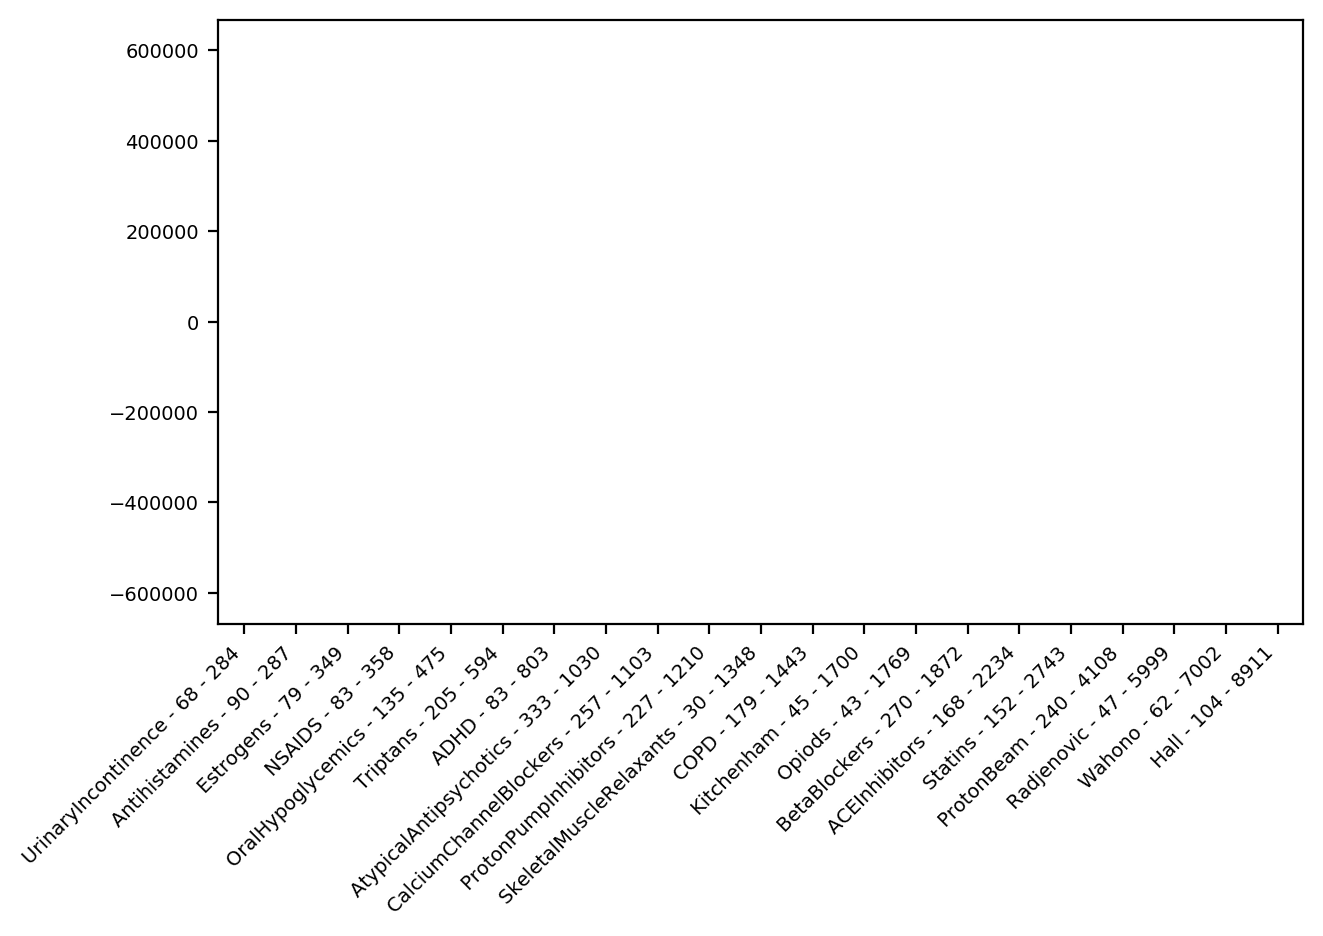

In [42]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

pdf = results_df[results_df['N'] > 1000]

datasets = results_df.groupby(['dataset','r_docs','N']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat([datasets['r_docs'].astype(str), datasets['N'].astype(str)], sep = " - ")

ax.boxplot([results_df[results_df['dataset']==d]['wss_rs'].dropna() for d in datasets['dataset']], whis=[5,95])

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")

KeyError: 'wss95_hyper'

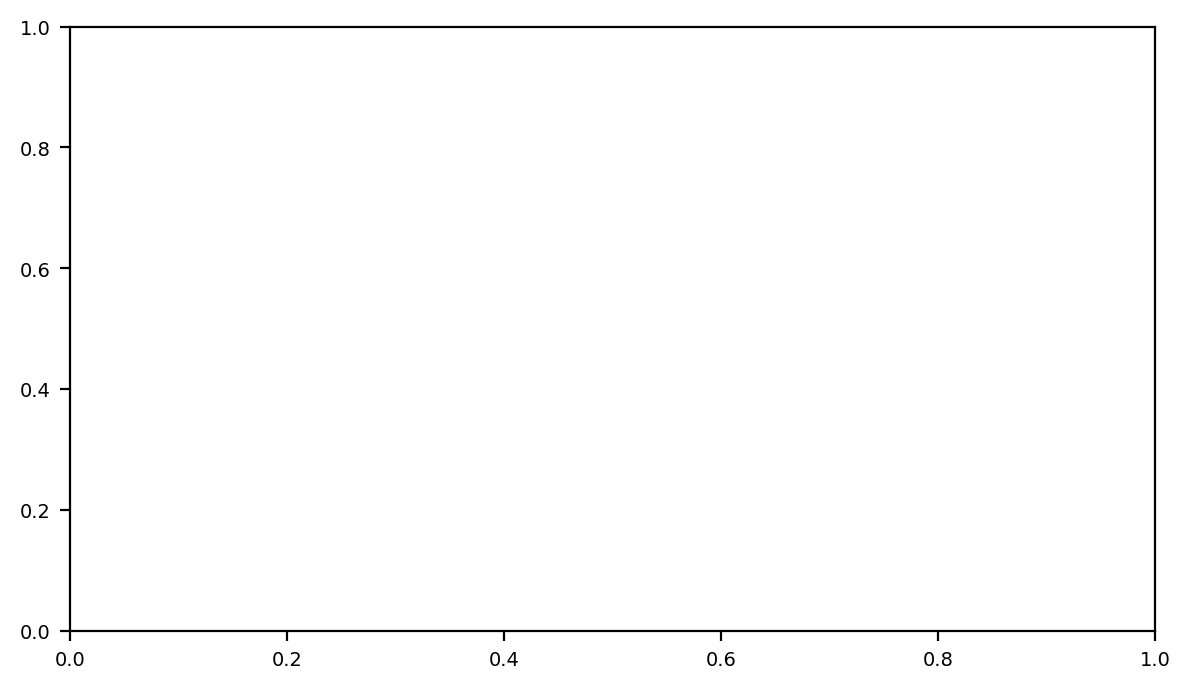

In [43]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

pdf = results_df[results_df['N'] > 1000]

datasets = results_df.groupby(['dataset','N']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat(datasets['N'].astype(str), sep = " - ")

ax.boxplot([results_df[results_df['dataset']==d]['wss95_hyper'].dropna() for d in datasets['dataset']], whis=[5,95])

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")

In [ ]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

pdf = results_df#[results_df['N'] > 1000]

datasets = results_df.groupby(['dataset','N','r_docs']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat(datasets['r_docs'].astype(str), sep = " / ").str.cat(datasets['N'].astype(str), sep = " - ")


ax.boxplot([results_df[results_df['dataset']==d]['ab_s_hyper'].dropna() for d in datasets['dataset']], whis=[5,95])

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")

In [ ]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

pdf = results_df#[results_df['N'] > 1000]

datasets = results_df.groupby(['dataset','N','r_docs']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat(datasets['r_docs'].astype(str), sep = " / ").str.cat(datasets['N'].astype(str), sep = " - ")


ax.boxplot([results_df[results_df['dataset']==d]['ab_s_ih_50'].dropna() for d in datasets['dataset']], whis=[5,95])

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")